## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # was the line detected in the last iteration?
        self.detectedCounter = 0  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #recent good average x values of the fitted line over the last n iterations
        self.recent_bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit_list = None  
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units for the last n iterations
        self.curvatures = None 
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

# Define a class to receive the characteristics of each line detection
class globalVar():
    def __init__(self):
        # frame counter
        self.value = 0

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        #print(objpoints, ', ', imgpoints)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

# Use cv2.calibrateCamera() and cv2.undistort()
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
print(mtx, dist)
cv2.destroyAllWindows()

[[1.15777930e+03 0.00000000e+00 6.67111054e+02]
 [0.00000000e+00 1.15282291e+03 3.86128938e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] [[-0.24688775 -0.02373133 -0.00109842  0.00035108 -0.00258571]]


In [3]:
#Functions for Pipline

#undistort the input image with the known parameter mtx and dist
def undistortImg(img, mtx, dist):
    imgUndistort = cv2.undistort(img, mtx, dist, None, mtx)
    return imgUndistort

#warp the preprocessed binary image
def warpImg(img,X,Y):

    src = np.float32([[(1-X)/2*img.shape[1],Y*img.shape[0]],[0,img.shape[0]],
                      [img.shape[1],img.shape[0]],[(1+X)/2*img.shape[1],Y*img.shape[0]]])
    #print(img.shape)
    dst = np.float32([[0,0],[0,img.shape[0]],[img.shape[1],img.shape[0]],[img.shape[1],0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    #delete the next two lines
    return warped, M

# Edge Detection
def edgeDetection(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return color_binary

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current-margin  # Update this
        win_xleft_high = leftx_current+margin  # Update this
        win_xright_low = rightx_current-margin  # Update this
        win_xright_high = rightx_current+margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #init find lane line flag and set them to false
        fLeftFound = False
        fRightFound = False
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        if (len(good_left_inds)>minpix):
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            fLeftFound = True
            
        if (len(good_right_inds)>minpix):
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            fRightFound = True
            
        ### (`right` or `leftx_current`) on their mean position ###
        #pass # Remove this when you add your function

    # Concatenate the arrays of indices (previously was a list of lists of pixels)

    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img, fLeftFound, fRightFound


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img, fLeftFound, fRightFound = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fitx, right_fitx, left_fit, right_fit, ploty, fLeftFound, fRightFound

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit

def search_around_poly(binary_warped, left_fit_last, right_fit_last):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit_last[0]*nonzeroy**2 + left_fit_last[1]
    *nonzeroy + left_fit_last[2] - margin)) & (nonzerox < (left_fit_last[0]*nonzeroy
    **2 + left_fit_last[1]*nonzeroy + left_fit_last[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit_last[0]*nonzeroy**2 + right_fit_last[1]
    *nonzeroy + right_fit_last[2] - margin)) & (nonzerox < (right_fit_last[0]*nonzeroy
    **2 + right_fit_last[1]*nonzeroy + right_fit_last[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    

    # Fit new polynomials
    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    if(len(leftx)<10000):
        left_fit = left_fit_last
        fLeftFound = False
    else:
        fLeftFound = True
        
    if(len(rightx)<10000):
        right_fit = right_fit_last
        fRightFound = False
    else:
        fRightFound = True
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, left_fitx, right_fitx, left_fit, right_fit, ploty, fLeftFound, fRightFound

In [26]:
#smooth function for 2 D array
def lineSmooth(xlist, x, n):
    xlist = np.append(xlist, [x], axis=0)
    if(len(xlist) > n):
        xlist = np.delete(xlist, 0, axis=0)
    return xlist

#smooth function for list
def simpleSmooth(xlist, x, n):
    #print(xlist.shape)
    xlist = np.append(xlist, x)
    if(len(xlist) > n):
        xlist = np.delete(xlist, 0)
    return xlist

In [27]:
def measure_curvature_real(ploty, left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 2.9/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    #calculation of R_curve (radius of curvature) #####
    left_curverad = (1+(2*left_fit_cr[0]*y_eval*ym_per_pix+left_fit_cr[1])**2)**1.5/np.abs(2*left_fit_cr[0])  ## Implement the calculation of the left line here
    right_curverad = (1+(2*right_fit_cr[0]*y_eval*ym_per_pix+right_fit_cr[1])**2)**1.5/np.abs(2*right_fit_cr[0])  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad

In [34]:
#draw the detected lines back on the original image
def drawLines(undist, warped, left_fitx, right_fitx, ploty, X, Y, color):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), color)
    
    dst = np.float32([[(1-X)/2*img.shape[1],Y*img.shape[0]],[0,img.shape[0]],
                      [img.shape[1],img.shape[0]],[(1+X)/2*img.shape[1],Y*img.shape[0]]])

    src = np.float32([[0,0],[0,img.shape[0]],[img.shape[1],img.shape[0]],[img.shape[1],0]])
    
    Minv = cv2.getPerspectiveTransform(src, dst)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result


In [35]:
#calculate lane center offset based on the left and right lane line position
def laneCenterCalc(left_fitx, right_fitx, imgWidth):
    xm_per_pix = 2.9/700 # meters per pixel in x dimension
    #use the 100 pixels close the bottom side to get the average position of left and right lane lines
    offset = round((imgWidth - np.mean(left_fitx[-100:]) - np.mean(right_fitx[-100:]))/2*xm_per_pix, 2)
    #print((-np.mean(left_fitx[-100:]) + np.mean(right_fitx[-100:]))*xm_per_pix)
    return offset

In [36]:
#compare two detected lane lines
def sanity_check(cur_L, cur_R, xfit_L, xfit_R, left_co, right_co, initCounter):
    #if the curvature of the lane line is above this limit, it is very close to straight line, no need to check similiraty of curvature
    cur_total_upper_lim = 10000
    #tuned this parameter based on standard high way width
    xm_per_pix = 2.9/700 # meters per pixel in x dimension
    #standard high way width in the US is 3.7m
    lane_width_standard = 3.7 #unit meter
    
    #threshold for the similar curvature, lane width and lane line parallel
    lim_cur = 100
    lim_width = 30
    lim_para = 200
    
    #calculate the difference between left cur and right cur in percentage
    cur_offset = np.abs(cur_L-cur_R)/cur_R*100
    #calculate the lane width and difference with standard lane width
    lane_width = (-np.mean(xfit_L[-100:]) + np.mean(xfit_R[-100:]))*xm_per_pix
    lane_width_offset = np.abs(lane_width-lane_width_standard)/lane_width_standard*100
    
    #calc if the two lines are roughly parallel
    para_offset = ((np.abs(left_co[0]-right_co[0])/right_co[0]) + (np.abs(left_co[1]-right_co[1])/right_co[1]) + 
     (np.abs(left_co[2]-right_co[2])/right_co[2]))*100
    
    if ((cur_L + cur_R)>cur_total_upper_lim):
        if (lane_width_offset > lim_width):
            initCounter += 1
        else:
            initCounter = 0
    else:
        if ((cur_offset>lim_cur)or(lane_width_offset > lim_width)or(para_offset>lim_para)):
            initCounter += 1
        else:
            initCounter = 0

    #print(zSanityCounter.value)
    return initCounter

In [37]:
def process_image(image):
    #print current frame number
    print('Current frame: ', zFrame.value)
    
    #define warp parameter X, Y
    warpX = 0.17
    warpY = 0.63
    
    #define n for detection result smooth
    n = 20
    
    #undistort the image with camera calibration results
    image_undistort = undistortImg(image, mtx, dist)
    
    #detect edge of the frame with combined gradient and color method
    image_edge = edgeDetection(image_undistort, s_thresh=(170, 255), sx_thresh=(20, 100))
    
    #warp the edge detection result frame to get a "bird view" picture
    image_warped, M = warpImg(image_edge,warpX,warpY)
    
    #convert the warped image to gray scale
    image_gray = cv2.cvtColor(image_warped, cv2.COLOR_RGB2GRAY)

    #normal mode: detect lane lines with known poly fit
    if(left_Line.detected and right_Line.detected and zSanityCounter.value < n):
        print('Normal Mode')
        result, left_fitx, right_fitx, left_fit, right_fit, ploty, fLeftFound, fRightFound = search_around_poly(image_gray, 
        left_Line.best_fit, right_Line.best_fit)
        
    #initilization mode: detect with slide window method
    else:
        print('Init Mode')
        result, left_fitx, right_fitx, left_fit, right_fit, ploty, fLeftFound, fRightFound = fit_polynomial(image_gray)
    
    # was the line detected in the last iteration?
    left_Line.detected = fLeftFound
    right_Line.detected = fRightFound
    
    # x values of the last n fits of the line
    left_Line.recent_xfitted = lineSmooth(left_Line.recent_xfitted, left_fitx, n)
    right_Line.recent_xfitted = lineSmooth(right_Line.recent_xfitted, right_fitx, n)
    
    #average x values of the fitted line over the last n iterations
    left_Line.bestx = np.mean(left_Line.recent_xfitted, axis=0)
    right_Line.bestx = np.mean(right_Line.recent_xfitted, axis=0)
    
    #polynomial coefficients averaged over the last n iterations
    left_Line.best_fit_list = lineSmooth(left_Line.best_fit_list, left_fit, n)
    right_Line.best_fit_list = lineSmooth(right_Line.best_fit_list, right_fit, n)
    left_Line.best_fit = np.mean(left_Line.best_fit_list, axis=0)
    right_Line.best_fit = np.mean(right_Line.best_fit_list, axis=0)
    
    #polynomial coefficients for the most recent fit: by pass

    #left_Line.radius_of_curvature, right_Line.radius_of_curvature = measure_curvature_pixels(ploty, left_Line.best_fit, right_Line.best_fit)
    left_Line.radius_of_curvature, right_Line.radius_of_curvature = measure_curvature_real(ploty, left_fit, right_fit)
    left_Line.curvatures = simpleSmooth(left_Line.curvatures, left_Line.radius_of_curvature, n)
    left_Line.radius_of_curvature = np.mean(left_Line.curvatures)
    right_Line.curvatures = simpleSmooth(right_Line.curvatures, right_Line.radius_of_curvature, n)
    right_Line.radius_of_curvature = np.mean(right_Line.curvatures)

    #distance in meters of vehicle center from the line, negative means vechile center on the left side of the lane center
    left_Line.line_base_pos = laneCenterCalc(left_Line.bestx, right_Line.bestx, image.shape[1])
    right_Line.line_base_pos = laneCenterCalc(left_Line.bestx, right_Line.bestx, image.shape[1])
    
    #sanity check
    zSanityCounter.value = sanity_check(left_Line.radius_of_curvature, right_Line.radius_of_curvature,
                 left_Line.bestx, right_Line.bestx, left_Line.best_fit, right_Line.best_fit, zSanityCounter.value)
    
    #when init lane detection, draw detection area with red color
    if (left_Line.detected and right_Line.detected and zSanityCounter.value < n):
        color = (0,255,0)
    else:
        color = (255,0,0)
    
    #draw the detected/take over lane line on the original undistort image
    result = drawLines(image_undistort, image_gray, left_Line.bestx, right_Line.bestx, ploty, warpX, warpY, color)

    #GUI Info
    #define the text and corresponding info
    txt_curvature = 'lane radius: ' + str(round((left_Line.radius_of_curvature+right_Line.radius_of_curvature)/2, 2)) + 'm'
    txt_offset = 'offset: ' + str(left_Line.line_base_pos) + 'm'
    txt_sanity = 'sanity check fail: ' + str(zSanityCounter.value)
    
    org_curvature = (20, 50)
    org_offset = (20, 100)
    org_sanity = (20, 150)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 1
    color = (255,255,255)
    thickness = 2
    
    result = cv2.putText(result, txt_offset, org_offset, font, fontScale, color, thickness, cv2.LINE_AA) 
    result = cv2.putText(result, txt_curvature, org_curvature, font, fontScale, color, thickness, cv2.LINE_AA) 
    result = cv2.putText(result, txt_sanity, org_sanity, font, fontScale, color, thickness, cv2.LINE_AA) 
    
    #frame counter add 1
    zFrame.value += 1
    
    return result

t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

Current frame:  1
Init Mode
Moviepy - Building video project_video_out.mp4.
Moviepy - Writing video project_video_out.mp4

Current frame:  2
Normal Mode
Current frame: 

t:   0%|▏                                                                   | 3/1260 [00:00<01:13, 17.13it/s, now=None]

 3
Normal Mode
Current frame:  4
Normal Mode
Current frame:  5
Normal Mode


t:   1%|▍                                                                   | 7/1260 [00:00<01:28, 14.12it/s, now=None]

Current frame:  6
Normal Mode
Current frame:  7
Normal Mode
Current frame:  8


t:   1%|▍                                                                   | 9/1260 [00:00<01:33, 13.31it/s, now=None]

Normal Mode
Current frame:  9
Normal Mode
Current frame:  10
Normal Mode
Current frame:  11


t:   1%|▌                                                                  | 11/1260 [00:00<01:35, 13.03it/s, now=None]

Normal Mode
Current frame:  12
Normal Mode
Current frame:  13
Normal Mode


t:   1%|▊                                                                  | 15/1260 [00:01<01:38, 12.60it/s, now=None]

Current frame:  14
Normal Mode
Current frame:  15
Normal Mode
Current frame:  16


t:   1%|▉                                                                  | 17/1260 [00:01<01:40, 12.41it/s, now=None]

Normal Mode
Current frame:  17
Normal Mode
Current frame:  18
Normal Mode
Current frame: 

t:   2%|█                                                                  | 19/1260 [00:01<01:40, 12.34it/s, now=None]

 19
Normal Mode
Current frame:  20
Normal Mode
Current frame:  21
Normal Mode

t:   2%|█                                                                  | 21/1260 [00:01<01:42, 12.12it/s, now=None]


Current frame:  22
Normal Mode
Current frame:  23
Normal Mode


t:   2%|█▎                                                                 | 25/1260 [00:02<01:44, 11.82it/s, now=None]

Current frame:  24
Normal Mode
Current frame:  25
Normal Mode
Current frame:  26
Normal Mode

t:   2%|█▍                                                                 | 27/1260 [00:02<01:43, 11.93it/s, now=None]


Current frame:  27
Normal Mode
Current frame:  28
Normal Mode
Current frame: 

t:   2%|█▌                                                                 | 29/1260 [00:02<01:49, 11.27it/s, now=None]

 29
Normal Mode
Current frame:  30
Normal Mode
Current frame: 

t:   2%|█▋                                                                 | 31/1260 [00:02<01:47, 11.47it/s, now=None]

 31
Normal Mode
Current frame:  32
Normal Mode
Current frame:  33
Normal Mode

t:   3%|█▊                                                                 | 33/1260 [00:02<01:45, 11.64it/s, now=None]


Current frame:  34
Normal Mode
Current frame:  35
Normal Mode


t:   3%|█▉                                                                 | 37/1260 [00:03<01:42, 11.97it/s, now=None]

Current frame:  36
Normal Mode
Current frame:  37
Normal Mode
Current frame:  38
Normal Mode

t:   3%|██                                                                 | 39/1260 [00:03<01:40, 12.18it/s, now=None]


Current frame:  39
Normal Mode
Current frame:  40
Normal Mode
Current frame: 

t:   3%|██▏                                                                | 41/1260 [00:03<01:39, 12.28it/s, now=None]

 41
Normal Mode
Current frame:  42
Normal Mode
Current frame:  43
Normal Mode

t:   3%|██▎                                                                | 43/1260 [00:03<01:39, 12.21it/s, now=None]


Current frame:  44
Normal Mode
Current frame:  45
Normal Mode


t:   4%|██▍                                                                | 47/1260 [00:03<01:39, 12.22it/s, now=None]

Current frame:  46
Normal Mode
Current frame:  47
Normal Mode
Current frame:  48
Normal Mode

t:   4%|██▌                                                                | 49/1260 [00:04<01:38, 12.25it/s, now=None]


Current frame:  49
Normal Mode
Current frame:  50
Normal Mode
Current frame: 

t:   4%|██▋                                                                | 51/1260 [00:04<01:37, 12.34it/s, now=None]

 51
Normal Mode
Current frame:  52
Normal Mode
Current frame:  53
Normal Mode

t:   4%|██▉                                                                | 55/1260 [00:04<01:36, 12.46it/s, now=None]


Current frame:  54
Normal Mode
Current frame:  55
Normal Mode


t:   5%|███                                                                | 57/1260 [00:04<01:37, 12.30it/s, now=None]

Current frame:  56
Normal Mode
Current frame:  57
Normal Mode
Current frame:  58


t:   5%|███▏                                                               | 59/1260 [00:04<01:36, 12.39it/s, now=None]

Normal Mode
Current frame:  59
Normal Mode
Current frame:  60
Normal Mode
Current frame: 

t:   5%|███▏                                                               | 61/1260 [00:04<01:39, 12.10it/s, now=None]

 61
Normal Mode
Current frame:  62
Normal Mode
Current frame:  63


t:   5%|███▎                                                               | 63/1260 [00:05<01:40, 11.94it/s, now=None]

Normal Mode
Current frame:  64
Normal Mode
Current frame:  65
Normal Mode

t:   5%|███▍                                                               | 65/1260 [00:05<01:43, 11.59it/s, now=None]


Current frame:  66
Normal Mode
Current frame:  67
Normal Mode


t:   5%|███▋                                                               | 69/1260 [00:05<01:45, 11.29it/s, now=None]

Current frame:  68
Normal Mode
Current frame:  69
Normal Mode
Current frame:  70


t:   6%|███▊                                                               | 71/1260 [00:05<01:44, 11.33it/s, now=None]

Normal Mode
Current frame:  71
Normal Mode
Current frame:  72
Normal Mode
Current frame: 

t:   6%|███▉                                                               | 73/1260 [00:06<01:43, 11.47it/s, now=None]

 73
Normal Mode
Current frame:  74
Normal Mode
Current frame:  75


t:   6%|████                                                               | 77/1260 [00:06<01:40, 11.81it/s, now=None]

Normal Mode
Current frame:  76
Normal Mode
Current frame:  77
Normal Mode


t:   6%|████▏                                                              | 79/1260 [00:06<01:38, 11.94it/s, now=None]

Current frame:  78
Normal Mode
Current frame:  79
Normal Mode
Current frame:  80


t:   6%|████▎                                                              | 81/1260 [00:06<01:38, 12.00it/s, now=None]

Normal Mode
Current frame:  81
Normal Mode
Current frame:  82
Normal Mode
Current frame: 

t:   7%|████▍                                                              | 83/1260 [00:06<01:57, 10.00it/s, now=None]

 83
Normal Mode


t:   7%|████▌                                                              | 85/1260 [00:07<01:50, 10.60it/s, now=None]

Current frame:  84
Normal Mode
Current frame:  85
Normal Mode
Current frame:  86


t:   7%|████▋                                                              | 87/1260 [00:07<01:49, 10.75it/s, now=None]

Normal Mode
Current frame:  87
Normal Mode
Current frame:  88
Normal Mode


t:   7%|████▋                                                              | 89/1260 [00:07<01:49, 10.70it/s, now=None]

Current frame:  89
Normal Mode
Current frame:  90
Normal Mode
Current frame:  91


t:   7%|████▉                                                              | 93/1260 [00:07<01:43, 11.31it/s, now=None]

Normal Mode
Current frame:  92
Normal Mode
Current frame:  93
Normal Mode


t:   8%|█████                                                              | 95/1260 [00:08<01:41, 11.47it/s, now=None]

Current frame:  94
Normal Mode
Current frame:  95
Normal Mode
Current frame:  96


t:   8%|█████▏                                                             | 97/1260 [00:08<01:40, 11.61it/s, now=None]

Normal Mode
Current frame:  97
Normal Mode
Current frame:  98
Normal Mode
Current frame: 

t:   8%|█████▎                                                             | 99/1260 [00:08<01:37, 11.91it/s, now=None]

 99
Normal Mode
Current frame:  100
Normal Mode
Current frame:  101


t:   8%|█████▎                                                            | 101/1260 [00:08<01:36, 12.00it/s, now=None]

Normal Mode
Current frame:  102
Normal Mode
Current frame:  103
Normal Mode


t:   8%|█████▌                                                            | 105/1260 [00:08<01:35, 12.11it/s, now=None]

Current frame:  104
Normal Mode
Current frame:  105
Normal Mode
Current frame:  106


t:   8%|█████▌                                                            | 107/1260 [00:09<01:35, 12.03it/s, now=None]

Normal Mode
Current frame:  107
Normal Mode
Current frame:  108
Normal Mode


t:   9%|█████▋                                                            | 109/1260 [00:09<01:35, 12.00it/s, now=None]

Current frame:  109
Normal Mode
Current frame:  110
Normal Mode
Current frame:  111
Normal Mode

t:   9%|█████▊                                                            | 111/1260 [00:09<01:35, 12.04it/s, now=None]


Current frame:  112
Normal Mode
Current frame:  113
Normal Mode


t:   9%|██████                                                            | 115/1260 [00:09<01:37, 11.74it/s, now=None]

Current frame:  114
Normal Mode
Current frame:  115
Normal Mode
Current frame:  116


t:   9%|██████▏                                                           | 117/1260 [00:09<01:36, 11.82it/s, now=None]

Normal Mode
Current frame:  117
Normal Mode
Current frame:  118
Normal Mode


t:   9%|██████▏                                                           | 119/1260 [00:10<01:36, 11.77it/s, now=None]

Current frame:  119
Normal Mode
Current frame:  120
Normal Mode
Current frame:  121


t:  10%|██████▍                                                           | 123/1260 [00:10<01:35, 11.94it/s, now=None]

Normal Mode
Current frame:  122
Normal Mode
Current frame:  123
Normal Mode


t:  10%|██████▌                                                           | 125/1260 [00:10<01:33, 12.13it/s, now=None]

Current frame:  124
Normal Mode
Current frame:  125
Normal Mode
Current frame:  126
Normal Mode

t:  10%|██████▋                                                           | 127/1260 [00:10<01:32, 12.26it/s, now=None]


Current frame:  127
Normal Mode
Current frame:  128
Normal Mode
Current frame: 

t:  10%|██████▊                                                           | 129/1260 [00:10<01:33, 12.15it/s, now=None]

 129
Normal Mode
Current frame:  130
Normal Mode
Current frame:  131


t:  10%|██████▊                                                           | 131/1260 [00:11<01:33, 12.02it/s, now=None]

Normal Mode
Current frame:  132
Normal Mode
Current frame:  133
Normal Mode


t:  11%|███████                                                           | 135/1260 [00:11<01:32, 12.19it/s, now=None]

Current frame:  134
Normal Mode
Current frame:  135
Normal Mode
Current frame:  136


t:  11%|███████▏                                                          | 137/1260 [00:11<01:31, 12.34it/s, now=None]

Normal Mode
Current frame:  137
Normal Mode
Current frame:  138
Normal Mode
Current frame: 

t:  11%|███████▎                                                          | 139/1260 [00:11<01:30, 12.42it/s, now=None]

 139
Normal Mode
Current frame:  140
Normal Mode
Current frame:  141
Normal Mode

t:  11%|███████▍                                                          | 141/1260 [00:11<01:30, 12.34it/s, now=None]


Current frame:  142
Normal Mode
Current frame:  143
Normal Mode


t:  12%|███████▌                                                          | 145/1260 [00:12<01:34, 11.82it/s, now=None]

Current frame:  144
Normal Mode
Current frame:  145
Normal Mode


t:  12%|███████▋                                                          | 147/1260 [00:12<01:33, 11.86it/s, now=None]

Current frame:  146
Normal Mode
Current frame:  147
Normal Mode
Current frame:  148


t:  12%|███████▊                                                          | 149/1260 [00:12<01:33, 11.91it/s, now=None]

Normal Mode
Current frame:  149
Normal Mode
Current frame:  150
Normal Mode


t:  12%|███████▉                                                          | 151/1260 [00:12<01:35, 11.65it/s, now=None]

Current frame:  151
Normal Mode
Current frame:  152
Normal Mode
Current frame:  153


t:  12%|████████                                                          | 153/1260 [00:12<01:36, 11.53it/s, now=None]

Normal Mode
Current frame:  154
Normal Mode
Current frame:  155
Normal Mode


t:  12%|████████▏                                                         | 157/1260 [00:13<01:33, 11.78it/s, now=None]

Current frame:  156
Normal Mode
Current frame:  157
Normal Mode
Current frame:  158


t:  13%|████████▎                                                         | 159/1260 [00:13<01:32, 11.89it/s, now=None]

Normal Mode
Current frame:  159
Normal Mode
Current frame:  160
Normal Mode
Current frame: 

t:  13%|████████▍                                                         | 161/1260 [00:13<01:31, 12.03it/s, now=None]

 161
Normal Mode
Current frame:  162
Normal Mode
Current frame:  163
Normal Mode

t:  13%|████████▌                                                         | 163/1260 [00:13<01:29, 12.25it/s, now=None]


Current frame:  164
Normal Mode
Current frame:  165
Normal Mode


t:  13%|████████▋                                                         | 167/1260 [00:14<01:29, 12.15it/s, now=None]

Current frame:  166
Normal Mode
Current frame:  167
Normal Mode
Current frame:  168


t:  13%|████████▊                                                         | 169/1260 [00:14<01:29, 12.18it/s, now=None]

Normal Mode
Current frame:  169
Normal Mode
Current frame:  170
Normal Mode
Current frame: 

t:  14%|████████▉                                                         | 171/1260 [00:14<01:29, 12.19it/s, now=None]

 171
Normal Mode
Current frame:  172
Normal Mode
Current frame:  173


t:  14%|█████████▏                                                        | 175/1260 [00:14<01:29, 12.18it/s, now=None]

Normal Mode
Current frame:  174
Normal Mode
Current frame:  175
Normal Mode


t:  14%|█████████▎                                                        | 177/1260 [00:14<01:29, 12.06it/s, now=None]

Current frame:  176
Normal Mode
Current frame:  177
Normal Mode
Current frame:  178


t:  14%|█████████▍                                                        | 179/1260 [00:15<01:31, 11.79it/s, now=None]

Normal Mode
Current frame:  179
Normal Mode
Current frame:  180
Normal Mode

t:  14%|█████████▍                                                        | 181/1260 [00:15<01:30, 11.94it/s, now=None]


Current frame:  181
Normal Mode
Current frame:  182
Normal Mode
Current frame: 

t:  15%|█████████▌                                                        | 183/1260 [00:15<01:29, 11.98it/s, now=None]

 183
Normal Mode
Current frame:  184
Normal Mode
Current frame:  185
Normal Mode

t:  15%|█████████▋                                                        | 185/1260 [00:15<01:29, 12.08it/s, now=None]


Current frame:  186
Normal Mode
Current frame:  187
Normal Mode


t:  15%|█████████▉                                                        | 189/1260 [00:15<01:27, 12.20it/s, now=None]

Current frame:  188
Normal Mode
Current frame:  189
Normal Mode
Current frame:  190
Normal Mode

t:  15%|██████████                                                        | 191/1260 [00:15<01:27, 12.27it/s, now=None]


Current frame:  191
Normal Mode
Current frame:  192
Normal Mode
Current frame: 

t:  15%|██████████                                                        | 193/1260 [00:16<01:26, 12.33it/s, now=None]

 193
Normal Mode
Current frame:  194
Normal Mode
Current frame:  195


t:  16%|██████████▎                                                       | 197/1260 [00:16<01:27, 12.19it/s, now=None]

Normal Mode
Current frame:  196
Normal Mode
Current frame:  197
Normal Mode


t:  16%|██████████▍                                                       | 199/1260 [00:16<01:27, 12.12it/s, now=None]

Current frame:  198
Normal Mode
Current frame:  199
Normal Mode
Current frame:  200


t:  16%|██████████▌                                                       | 201/1260 [00:16<01:26, 12.19it/s, now=None]

Normal Mode
Current frame:  201
Normal Mode
Current frame:  202
Normal Mode
Current frame: 

t:  16%|██████████▋                                                       | 203/1260 [00:16<01:27, 12.11it/s, now=None]

 203
Normal Mode
Current frame:  204
Normal Mode
Current frame:  205
Normal Mode

t:  16%|██████████▊                                                       | 207/1260 [00:17<01:27, 12.08it/s, now=None]


Current frame:  206
Normal Mode
Current frame:  207
Normal Mode


t:  17%|██████████▉                                                       | 209/1260 [00:17<01:27, 11.95it/s, now=None]

Current frame:  208
Normal Mode
Current frame:  209
Normal Mode
Current frame:  210


t:  17%|███████████                                                       | 211/1260 [00:17<01:26, 12.14it/s, now=None]

Normal Mode
Current frame:  211
Normal Mode
Current frame:  212
Normal Mode
Current frame: 

t:  17%|███████████▏                                                      | 213/1260 [00:17<01:25, 12.19it/s, now=None]

 213
Normal Mode
Current frame:  214
Normal Mode
Current frame:  215
Normal Mode

t:  17%|███████████▎                                                      | 215/1260 [00:17<01:26, 12.13it/s, now=None]


Current frame:  216
Normal Mode
Current frame:  217
Normal Mode


t:  17%|███████████▍                                                      | 219/1260 [00:18<01:24, 12.37it/s, now=None]

Current frame:  218
Normal Mode
Current frame:  219
Normal Mode
Current frame:  220
Normal Mode

t:  18%|███████████▌                                                      | 221/1260 [00:18<01:23, 12.39it/s, now=None]


Current frame:  221
Normal Mode
Current frame:  222
Normal Mode
Current frame: 

t:  18%|███████████▋                                                      | 223/1260 [00:18<01:22, 12.53it/s, now=None]

 223
Normal Mode
Current frame:  224
Normal Mode
Current frame:  225
Normal Mode

t:  18%|███████████▊                                                      | 225/1260 [00:18<01:22, 12.53it/s, now=None]


Current frame:  226
Normal Mode
Current frame:  227
Normal Mode


t:  18%|███████████▉                                                      | 229/1260 [00:19<01:23, 12.40it/s, now=None]

Current frame:  228
Normal Mode
Current frame:  229
Normal Mode
Current frame:  230


t:  18%|████████████                                                      | 231/1260 [00:19<01:23, 12.35it/s, now=None]

Normal Mode
Current frame:  231
Normal Mode
Current frame:  232
Normal Mode


t:  18%|████████████▏                                                     | 233/1260 [00:19<01:23, 12.29it/s, now=None]

Current frame:  233
Normal Mode
Current frame:  234
Normal Mode
Current frame:  235


t:  19%|████████████▎                                                     | 235/1260 [00:19<01:23, 12.29it/s, now=None]

Normal Mode
Current frame:  236
Normal Mode
Current frame:  237
Normal Mode


t:  19%|████████████▌                                                     | 239/1260 [00:19<01:23, 12.25it/s, now=None]

Current frame:  238
Normal Mode
Current frame:  239
Normal Mode
Current frame:  240
Normal Mode

t:  19%|████████████▌                                                     | 241/1260 [00:20<01:24, 12.00it/s, now=None]


Current frame:  241
Normal Mode
Current frame:  242
Normal Mode


t:  19%|████████████▋                                                     | 243/1260 [00:20<01:24, 12.03it/s, now=None]

Current frame:  243
Normal Mode
Current frame:  244
Normal Mode
Current frame:  245


t:  20%|████████████▉                                                     | 247/1260 [00:20<01:22, 12.26it/s, now=None]

Normal Mode
Current frame:  246
Normal Mode
Current frame:  247
Normal Mode


t:  20%|█████████████                                                     | 249/1260 [00:20<01:22, 12.25it/s, now=None]

Current frame:  248
Normal Mode
Current frame:  249
Normal Mode
Current frame:  250


t:  20%|█████████████▏                                                    | 251/1260 [00:20<01:22, 12.20it/s, now=None]

Normal Mode
Current frame:  251
Normal Mode
Current frame:  252
Normal Mode
Current frame: 

t:  20%|█████████████▎                                                    | 253/1260 [00:21<01:22, 12.14it/s, now=None]

 253
Normal Mode
Current frame:  254
Normal Mode
Current frame:  255
Normal Mode

t:  20%|█████████████▎                                                    | 255/1260 [00:21<01:22, 12.14it/s, now=None]


Current frame:  256
Normal Mode
Current frame:  257
Normal Mode


t:  21%|█████████████▌                                                    | 259/1260 [00:21<01:21, 12.32it/s, now=None]

Current frame:  258
Normal Mode
Current frame:  259
Normal Mode
Current frame:  260
Normal Mode

t:  21%|█████████████▋                                                    | 261/1260 [00:21<01:22, 12.16it/s, now=None]


Current frame:  261
Normal Mode
Current frame:  262
Normal Mode


t:  21%|█████████████▊                                                    | 263/1260 [00:21<01:21, 12.20it/s, now=None]

Current frame:  263
Normal Mode
Current frame:  264
Normal Mode
Current frame:  265


t:  21%|█████████████▉                                                    | 267/1260 [00:22<01:21, 12.11it/s, now=None]

Normal Mode
Current frame:  266
Normal Mode
Current frame:  267
Normal Mode


t:  21%|██████████████                                                    | 269/1260 [00:22<01:20, 12.24it/s, now=None]

Current frame:  268
Normal Mode
Current frame:  269
Normal Mode
Current frame:  270


t:  22%|██████████████▏                                                   | 271/1260 [00:22<01:20, 12.30it/s, now=None]

Normal Mode
Current frame:  271
Normal Mode
Current frame:  272
Normal Mode
Current frame: 

t:  22%|██████████████▎                                                   | 273/1260 [00:22<01:19, 12.46it/s, now=None]

 273
Normal Mode
Current frame:  274
Normal Mode
Current frame:  275


t:  22%|██████████████▌                                                   | 277/1260 [00:23<01:20, 12.23it/s, now=None]

Normal Mode
Current frame:  276
Normal Mode
Current frame:  277
Normal Mode


t:  22%|██████████████▌                                                   | 279/1260 [00:23<01:19, 12.34it/s, now=None]

Current frame:  278
Normal Mode
Current frame:  279
Normal Mode
Current frame:  280


t:  22%|██████████████▋                                                   | 281/1260 [00:23<01:20, 12.13it/s, now=None]

Normal Mode
Current frame:  281
Normal Mode
Current frame:  282
Normal Mode
Current frame: 

t:  22%|██████████████▊                                                   | 283/1260 [00:23<01:21, 11.92it/s, now=None]

 283
Normal Mode
Current frame:  284
Normal Mode
Current frame:  285
Normal Mode

t:  23%|██████████████▉                                                   | 285/1260 [00:23<01:21, 11.99it/s, now=None]


Current frame:  286
Normal Mode
Current frame:  287
Normal Mode


t:  23%|███████████████▏                                                  | 289/1260 [00:24<01:21, 11.94it/s, now=None]

Current frame:  288
Normal Mode
Current frame:  289
Normal Mode
Current frame:  290


t:  23%|███████████████▏                                                  | 291/1260 [00:24<01:19, 12.24it/s, now=None]

Normal Mode
Current frame:  291
Normal Mode
Current frame:  292
Normal Mode
Current frame: 

t:  23%|███████████████▎                                                  | 293/1260 [00:24<01:20, 11.95it/s, now=None]

 293
Normal Mode
Current frame:  294
Normal Mode
Current frame:  295
Normal Mode

t:  24%|███████████████▌                                                  | 297/1260 [00:24<01:18, 12.26it/s, now=None]


Current frame:  296
Normal Mode
Current frame:  297
Normal Mode


t:  24%|███████████████▋                                                  | 299/1260 [00:24<01:17, 12.34it/s, now=None]

Current frame:  298
Normal Mode
Current frame:  299
Normal Mode
Current frame:  300


t:  24%|███████████████▊                                                  | 301/1260 [00:24<01:17, 12.37it/s, now=None]

Normal Mode
Current frame:  301
Normal Mode
Current frame:  302
Normal Mode
Current frame: 

t:  24%|███████████████▊                                                  | 303/1260 [00:25<01:16, 12.51it/s, now=None]

 303
Normal Mode
Current frame:  304
Normal Mode
Current frame:  305
Normal Mode

t:  24%|████████████████                                                  | 307/1260 [00:25<01:16, 12.43it/s, now=None]


Current frame:  306
Normal Mode
Current frame:  307
Normal Mode


t:  25%|████████████████▏                                                 | 309/1260 [00:25<01:17, 12.23it/s, now=None]

Current frame:  308
Normal Mode
Current frame:  309
Normal Mode
Current frame:  310


t:  25%|████████████████▎                                                 | 311/1260 [00:25<01:18, 12.12it/s, now=None]

Normal Mode
Current frame:  311
Normal Mode
Current frame:  312
Normal Mode
Current frame: 

t:  25%|████████████████▍                                                 | 313/1260 [00:25<01:18, 12.00it/s, now=None]

 313
Normal Mode
Current frame:  314
Normal Mode
Current frame:  315


t:  25%|████████████████▌                                                 | 315/1260 [00:26<01:17, 12.13it/s, now=None]

Normal Mode
Current frame:  316
Normal Mode
Current frame:  317
Normal Mode


t:  25%|████████████████▋                                                 | 319/1260 [00:26<01:17, 12.16it/s, now=None]

Current frame:  318
Normal Mode
Current frame:  319
Normal Mode
Current frame:  320
Normal Mode

t:  25%|████████████████▊                                                 | 321/1260 [00:26<01:18, 12.03it/s, now=None]


Current frame:  321
Normal Mode
Current frame:  322
Normal Mode


t:  26%|████████████████▉                                                 | 323/1260 [00:26<01:18, 11.98it/s, now=None]

Current frame:  323
Normal Mode
Current frame:  324
Normal Mode
Current frame:  325
Normal Mode


t:  26%|█████████████████▏                                                | 327/1260 [00:27<01:16, 12.17it/s, now=None]

Current frame:  326
Normal Mode
Current frame:  327
Normal Mode
Current frame:  328
Normal Mode

t:  26%|█████████████████▏                                                | 329/1260 [00:27<01:16, 12.10it/s, now=None]


Current frame:  329
Normal Mode
Current frame:  330
Normal Mode
Current frame: 

t:  26%|█████████████████▎                                                | 331/1260 [00:27<01:16, 12.16it/s, now=None]

 331
Normal Mode
Current frame:  332
Normal Mode
Current frame:  333
Normal Mode

t:  26%|█████████████████▍                                                | 333/1260 [00:27<01:15, 12.25it/s, now=None]


Current frame:  334
Normal Mode
Current frame:  335
Normal Mode


t:  27%|█████████████████▋                                                | 337/1260 [00:27<01:16, 12.04it/s, now=None]

Current frame:  336
Normal Mode
Current frame:  337
Normal Mode
Current frame:  338


t:  27%|█████████████████▊                                                | 339/1260 [00:28<01:16, 12.07it/s, now=None]

Normal Mode
Current frame:  339
Normal Mode
Current frame:  340
Normal Mode
Current frame: 

t:  27%|█████████████████▊                                                | 341/1260 [00:28<01:16, 12.07it/s, now=None]

 341
Normal Mode
Current frame:  342
Normal Mode
Current frame:  343
Normal Mode

t:  27%|█████████████████▉                                                | 343/1260 [00:28<01:15, 12.19it/s, now=None]


Current frame:  344
Normal Mode
Current frame:  345
Normal Mode


t:  28%|██████████████████▏                                               | 347/1260 [00:28<01:13, 12.43it/s, now=None]

Current frame:  346
Normal Mode
Current frame:  347
Normal Mode
Current frame:  348


t:  28%|██████████████████▎                                               | 349/1260 [00:28<01:13, 12.44it/s, now=None]

Normal Mode
Current frame:  349
Normal Mode
Current frame:  350
Normal Mode

t:  28%|██████████████████▍                                               | 351/1260 [00:29<01:14, 12.22it/s, now=None]


Current frame:  351
Normal Mode
Current frame:  352
Normal Mode
Current frame:  353


t:  28%|██████████████████▍                                               | 353/1260 [00:29<01:13, 12.31it/s, now=None]

Normal Mode
Current frame:  354
Normal Mode
Current frame:  355
Normal Mode


t:  28%|██████████████████▋                                               | 357/1260 [00:29<01:13, 12.31it/s, now=None]

Current frame:  356
Normal Mode
Current frame:  357
Normal Mode
Current frame:  358


t:  28%|██████████████████▊                                               | 359/1260 [00:29<01:14, 12.17it/s, now=None]

Normal Mode
Current frame:  359
Normal Mode
Current frame:  360
Normal Mode
Current frame: 

t:  29%|██████████████████▉                                               | 361/1260 [00:29<01:13, 12.23it/s, now=None]

 361
Normal Mode
Current frame:  362
Normal Mode
Current frame:  363
Normal Mode

t:  29%|███████████████████                                               | 365/1260 [00:30<01:13, 12.20it/s, now=None]


Current frame:  364
Normal Mode
Current frame:  365
Normal Mode


t:  29%|███████████████████▏                                              | 367/1260 [00:30<01:15, 11.82it/s, now=None]

Current frame:  366
Normal Mode
Current frame:  367
Normal Mode


t:  29%|███████████████████▎                                              | 369/1260 [00:30<01:15, 11.86it/s, now=None]

Current frame:  368
Normal Mode
Current frame:  369
Normal Mode
Current frame:  370


t:  29%|███████████████████▍                                              | 371/1260 [00:30<01:14, 11.88it/s, now=None]

Normal Mode
Current frame:  371
Normal Mode
Current frame:  372
Normal Mode
Current frame: 

t:  30%|███████████████████▌                                              | 373/1260 [00:30<01:13, 12.05it/s, now=None]

 373
Normal Mode
Current frame:  374
Normal Mode
Current frame:  375


t:  30%|███████████████████▋                                              | 375/1260 [00:31<01:14, 11.91it/s, now=None]

Normal Mode
Current frame:  376
Normal Mode
Current frame:  377
Normal Mode


t:  30%|███████████████████▊                                              | 379/1260 [00:31<01:12, 12.07it/s, now=None]

Current frame:  378
Normal Mode
Current frame:  379
Normal Mode
Current frame:  380


t:  30%|███████████████████▉                                              | 381/1260 [00:31<01:13, 11.95it/s, now=None]

Normal Mode
Current frame:  381
Normal Mode
Current frame:  382
Normal Mode

t:  30%|████████████████████                                              | 383/1260 [00:31<01:13, 11.97it/s, now=None]


Current frame:  383
Normal Mode
Current frame:  384
Normal Mode
Current frame: 

t:  31%|████████████████████▏                                             | 385/1260 [00:31<01:13, 11.91it/s, now=None]

 385
Normal Mode
Current frame:  386
Normal Mode
Current frame:  387
Normal Mode

t:  31%|████████████████████▍                                             | 389/1260 [00:32<01:11, 12.16it/s, now=None]


Current frame:  388
Normal Mode
Current frame:  389
Normal Mode


t:  31%|████████████████████▍                                             | 391/1260 [00:32<01:12, 12.07it/s, now=None]

Current frame:  390
Normal Mode
Current frame:  391
Normal Mode
Current frame:  392


t:  31%|████████████████████▌                                             | 393/1260 [00:32<01:10, 12.25it/s, now=None]

Normal Mode
Current frame:  393
Normal Mode
Current frame:  394
Normal Mode


t:  31%|████████████████████▋                                             | 395/1260 [00:32<01:12, 11.96it/s, now=None]

Current frame:  395
Normal Mode
Current frame:  396
Normal Mode
Current frame: 

t:  32%|████████████████████▊                                             | 397/1260 [00:32<01:11, 11.99it/s, now=None]

 397
Normal Mode
Current frame:  398
Normal Mode
Current frame:  399
Normal Mode

t:  32%|████████████████████▉                                             | 399/1260 [00:33<01:11, 12.06it/s, now=None]


Current frame:  400
Normal Mode
Current frame:  401
Normal Mode


t:  32%|█████████████████████                                             | 403/1260 [00:33<01:09, 12.35it/s, now=None]

Current frame:  402
Normal Mode
Current frame:  403
Normal Mode
Current frame:  404
Normal Mode

t:  32%|█████████████████████▏                                            | 405/1260 [00:33<01:08, 12.41it/s, now=None]


Current frame:  405
Normal Mode
Current frame:  406
Normal Mode
Current frame: 

t:  32%|█████████████████████▎                                            | 407/1260 [00:33<01:08, 12.47it/s, now=None]

 407
Normal Mode
Current frame:  408
Normal Mode
Current frame:  409
Normal Mode

t:  32%|█████████████████████▍                                            | 409/1260 [00:33<01:10, 12.10it/s, now=None]


Current frame:  410
Normal Mode
Current frame:  411
Normal Mode


t:  33%|█████████████████████▋                                            | 413/1260 [00:34<01:10, 12.01it/s, now=None]

Current frame:  412
Normal Mode
Current frame:  413
Normal Mode
Current frame:  414


t:  33%|█████████████████████▋                                            | 415/1260 [00:34<01:10, 11.92it/s, now=None]

Normal Mode
Current frame:  415
Normal Mode
Current frame:  416
Normal Mode
Current frame: 

t:  33%|█████████████████████▊                                            | 417/1260 [00:34<01:09, 12.10it/s, now=None]

 417
Normal Mode
Current frame:  418
Normal Mode
Current frame:  419
Normal Mode

t:  33%|█████████████████████▉                                            | 419/1260 [00:34<01:08, 12.23it/s, now=None]


Current frame:  420
Normal Mode
Current frame:  421
Normal Mode


t:  34%|██████████████████████▏                                           | 423/1260 [00:35<01:09, 12.10it/s, now=None]

Current frame:  422
Normal Mode
Current frame:  423
Normal Mode
Current frame:  424
Normal Mode

t:  34%|██████████████████████▎                                           | 425/1260 [00:35<01:08, 12.25it/s, now=None]


Current frame:  425
Normal Mode
Current frame:  426
Normal Mode
Current frame: 

t:  34%|██████████████████████▎                                           | 427/1260 [00:35<01:07, 12.26it/s, now=None]

 427
Normal Mode
Current frame:  428
Normal Mode
Current frame:  429


t:  34%|██████████████████████▌                                           | 431/1260 [00:35<01:09, 12.01it/s, now=None]

Normal Mode
Current frame:  430
Normal Mode
Current frame:  431
Normal Mode


t:  34%|██████████████████████▋                                           | 433/1260 [00:35<01:07, 12.21it/s, now=None]

Current frame:  432
Normal Mode
Current frame:  433
Normal Mode
Current frame:  434


t:  35%|██████████████████████▊                                           | 435/1260 [00:36<01:08, 12.10it/s, now=None]

Normal Mode
Current frame:  435
Normal Mode
Current frame:  436
Normal Mode
Current frame: 

t:  35%|██████████████████████▉                                           | 437/1260 [00:36<01:07, 12.23it/s, now=None]

 437
Normal Mode
Current frame:  438
Normal Mode
Current frame:  439
Normal Mode

t:  35%|██████████████████████▉                                           | 439/1260 [00:36<01:08, 11.97it/s, now=None]


Current frame:  440
Normal Mode
Current frame:  441
Normal Mode


t:  35%|███████████████████████▏                                          | 443/1260 [00:36<01:07, 12.05it/s, now=None]

Current frame:  442
Normal Mode
Current frame:  443
Normal Mode
Current frame:  444


t:  35%|███████████████████████▎                                          | 445/1260 [00:36<01:06, 12.17it/s, now=None]

Normal Mode
Current frame:  445
Normal Mode
Current frame:  446
Normal Mode
Current frame: 

t:  35%|███████████████████████▍                                          | 447/1260 [00:37<01:06, 12.23it/s, now=None]

 447
Normal Mode
Current frame:  448
Normal Mode
Current frame:  449
Normal Mode

t:  36%|███████████████████████▌                                          | 449/1260 [00:37<01:06, 12.28it/s, now=None]


Current frame:  450
Normal Mode
Current frame:  451
Normal Mode


t:  36%|███████████████████████▋                                          | 453/1260 [00:37<01:05, 12.29it/s, now=None]

Current frame:  452
Normal Mode
Current frame:  453
Normal Mode
Current frame:  454


t:  36%|███████████████████████▊                                          | 455/1260 [00:37<01:05, 12.22it/s, now=None]

Normal Mode
Current frame:  455
Normal Mode
Current frame:  456
Normal Mode
Current frame: 

t:  36%|███████████████████████▉                                          | 457/1260 [00:37<01:05, 12.23it/s, now=None]

 457
Normal Mode
Current frame:  458
Normal Mode
Current frame:  459


t:  37%|████████████████████████▏                                         | 461/1260 [00:38<01:06, 12.10it/s, now=None]

Normal Mode
Current frame:  460
Normal Mode
Current frame:  461
Normal Mode


t:  37%|████████████████████████▎                                         | 463/1260 [00:38<01:06, 12.03it/s, now=None]

Current frame:  462
Normal Mode
Current frame:  463
Normal Mode
Current frame:  464


t:  37%|████████████████████████▎                                         | 465/1260 [00:38<01:05, 12.22it/s, now=None]

Normal Mode
Current frame:  465
Normal Mode
Current frame:  466
Normal Mode
Current frame: 

t:  37%|████████████████████████▍                                         | 467/1260 [00:38<01:05, 12.16it/s, now=None]

 467
Normal Mode
Current frame:  468
Normal Mode
Current frame:  469
Normal Mode

t:  37%|████████████████████████▌                                         | 469/1260 [00:38<01:05, 12.13it/s, now=None]


Current frame:  470
Normal Mode
Current frame:  471
Normal Mode


t:  38%|████████████████████████▊                                         | 473/1260 [00:39<01:03, 12.47it/s, now=None]

Current frame:  472
Normal Mode
Current frame:  473
Normal Mode
Current frame:  474


t:  38%|████████████████████████▉                                         | 475/1260 [00:39<01:03, 12.28it/s, now=None]

Normal Mode
Current frame:  475
Normal Mode
Current frame:  476
Normal Mode
Current frame: 

t:  38%|████████████████████████▉                                         | 477/1260 [00:39<01:03, 12.29it/s, now=None]

 477
Normal Mode
Current frame:  478
Normal Mode
Current frame:  479
Normal Mode

t:  38%|█████████████████████████                                         | 479/1260 [00:39<01:03, 12.20it/s, now=None]


Current frame:  480
Normal Mode
Current frame:  481
Normal Mode


t:  38%|█████████████████████████▎                                        | 483/1260 [00:39<01:04, 12.13it/s, now=None]

Current frame:  482
Normal Mode
Current frame:  483
Normal Mode
Current frame:  484


t:  38%|█████████████████████████▍                                        | 485/1260 [00:40<01:03, 12.23it/s, now=None]

Normal Mode
Current frame:  485
Normal Mode
Current frame:  486
Normal Mode
Current frame: 

t:  39%|█████████████████████████▌                                        | 487/1260 [00:40<01:02, 12.34it/s, now=None]

 487
Normal Mode
Current frame:  488
Normal Mode
Current frame:  489
Normal Mode

t:  39%|█████████████████████████▌                                        | 489/1260 [00:40<01:02, 12.28it/s, now=None]


Current frame:  490
Normal Mode
Current frame:  491
Normal Mode


t:  39%|█████████████████████████▊                                        | 493/1260 [00:40<01:03, 12.13it/s, now=None]

Current frame:  492
Normal Mode
Current frame:  493
Normal Mode
Current frame: 

t:  39%|█████████████████████████▉                                        | 495/1260 [00:40<01:03, 12.03it/s, now=None]

 494
Normal Mode
Current frame:  495
Normal Mode
Current frame:  496


t:  39%|██████████████████████████                                        | 497/1260 [00:41<01:02, 12.17it/s, now=None]

Normal Mode
Current frame:  497
Normal Mode
Current frame:  498
Normal Mode
Current frame: 

t:  40%|██████████████████████████▏                                       | 499/1260 [00:41<01:02, 12.08it/s, now=None]

 499
Normal Mode
Current frame:  500
Normal Mode
Current frame:  501
Normal Mode

t:  40%|██████████████████████████▎                                       | 503/1260 [00:41<01:01, 12.35it/s, now=None]


Current frame:  502
Normal Mode
Current frame:  503
Normal Mode


t:  40%|██████████████████████████▍                                       | 505/1260 [00:41<01:01, 12.29it/s, now=None]

Current frame:  504
Normal Mode
Current frame:  505
Normal Mode
Current frame:  506


t:  40%|██████████████████████████▌                                       | 507/1260 [00:41<01:02, 12.03it/s, now=None]

Normal Mode
Current frame:  507
Normal Mode
Current frame:  508
Normal Mode


t:  40%|██████████████████████████▋                                       | 509/1260 [00:42<01:01, 12.15it/s, now=None]

Current frame:  509
Normal Mode
Current frame:  510
Normal Mode
Current frame:  511
Normal Mode

t:  41%|██████████████████████████▊                                       | 511/1260 [00:42<01:01, 12.11it/s, now=None]


Current frame:  512
Normal Mode
Current frame:  513
Normal Mode

t:  41%|██████████████████████████▊                                       | 513/1260 [00:42<01:03, 11.74it/s, now=None]


Current frame:  514
Normal Mode
Current frame:  515
Normal Mode


t:  41%|███████████████████████████                                       | 517/1260 [00:42<01:02, 11.87it/s, now=None]

Current frame:  516
Normal Mode
Current frame:  517
Normal Mode
Current frame:  518


t:  41%|███████████████████████████▏                                      | 519/1260 [00:42<01:02, 11.82it/s, now=None]

Normal Mode
Current frame:  519
Normal Mode
Current frame:  520
Normal Mode


t:  41%|███████████████████████████▎                                      | 521/1260 [00:43<01:02, 11.79it/s, now=None]

Current frame:  521
Normal Mode
Current frame:  522
Normal Mode
Current frame:  523


t:  42%|███████████████████████████▍                                      | 523/1260 [00:43<01:02, 11.84it/s, now=None]

Normal Mode
Current frame:  524
Normal Mode
Current frame:  525
Normal Mode


t:  42%|███████████████████████████▌                                      | 527/1260 [00:43<01:02, 11.69it/s, now=None]

Current frame:  526
Normal Mode
Current frame:  527
Normal Mode
Current frame:  528


t:  42%|███████████████████████████▋                                      | 529/1260 [00:43<01:02, 11.78it/s, now=None]

Normal Mode
Current frame:  529
Normal Mode
Current frame:  530
Normal Mode
Current frame: 

t:  42%|███████████████████████████▊                                      | 531/1260 [00:43<01:01, 11.93it/s, now=None]

 531
Normal Mode
Current frame:  532
Normal Mode
Current frame:  533
Normal Mode

t:  42%|███████████████████████████▉                                      | 533/1260 [00:44<00:59, 12.29it/s, now=None]


Current frame:  534
Normal Mode
Current frame:  535
Normal Mode


t:  43%|████████████████████████████▏                                     | 537/1260 [00:44<01:01, 11.83it/s, now=None]

Current frame:  536
Normal Mode
Current frame:  537
Normal Mode


t:  43%|████████████████████████████▏                                     | 539/1260 [00:44<01:02, 11.60it/s, now=None]

Current frame:  538
Normal Mode
Current frame:  539
Normal Mode
Current frame:  540


t:  43%|████████████████████████████▎                                     | 541/1260 [00:44<01:00, 11.88it/s, now=None]

Normal Mode
Current frame:  541
Normal Mode
Current frame:  542
Normal Mode
Current frame: 

t:  43%|████████████████████████████▍                                     | 543/1260 [00:44<01:00, 11.92it/s, now=None]

 543
Normal Mode
Current frame:  544
Normal Mode
Current frame:  545


t:  43%|████████████████████████████▌                                     | 545/1260 [00:45<01:00, 11.86it/s, now=None]

Normal Mode
Current frame:  546
Normal Mode
Current frame:  547
Normal Mode


t:  44%|████████████████████████████▊                                     | 549/1260 [00:45<00:58, 12.12it/s, now=None]

Current frame:  548
Normal Mode
Current frame:  549
Normal Mode
Current frame:  550
Normal Mode

t:  44%|████████████████████████████▊                                     | 551/1260 [00:45<00:58, 12.11it/s, now=None]


Current frame:  551
Normal Mode
Current frame:  552
Normal Mode
Current frame: 

t:  44%|████████████████████████████▉                                     | 553/1260 [00:45<00:58, 12.17it/s, now=None]

 553
Normal Mode
Current frame:  554
Normal Mode
Current frame:  555
Normal Mode

t:  44%|█████████████████████████████                                     | 555/1260 [00:45<00:58, 12.14it/s, now=None]


Current frame:  556
Normal Mode
Current frame:  557
Normal Mode


t:  44%|█████████████████████████████▎                                    | 559/1260 [00:46<00:55, 12.62it/s, now=None]

Current frame:  558
Normal Mode
Current frame:  559
Normal Mode
Current frame:  560
Normal Mode

t:  45%|█████████████████████████████▍                                    | 561/1260 [00:46<00:55, 12.64it/s, now=None]


Current frame:  561
Normal Mode
Current frame:  562
Normal Mode
Current frame: 

t:  45%|█████████████████████████████▍                                    | 563/1260 [00:46<00:55, 12.66it/s, now=None]

 563
Normal Mode
Current frame:  564
Normal Mode
Current frame:  565
Normal Mode

t:  45%|█████████████████████████████▋                                    | 567/1260 [00:46<00:55, 12.53it/s, now=None]


Current frame:  566
Normal Mode
Current frame:  567
Init Mode


t:  45%|█████████████████████████████▊                                    | 569/1260 [00:47<00:54, 12.58it/s, now=None]

Current frame:  568
Normal Mode
Current frame:  569
Init Mode
Current frame:  570


t:  45%|█████████████████████████████▉                                    | 571/1260 [00:47<00:53, 12.93it/s, now=None]

Init Mode
Current frame:  571
Init Mode
Current frame:  572
Init Mode
Current frame:  573


t:  46%|██████████████████████████████                                    | 575/1260 [00:47<00:52, 13.17it/s, now=None]

Init Mode
Current frame:  574
Init Mode
Current frame:  575
Init Mode
Current frame:  576


t:  46%|██████████████████████████████▏                                   | 577/1260 [00:47<00:52, 13.07it/s, now=None]

Init Mode
Current frame:  577
Init Mode
Current frame:  578
Init Mode
Current frame: 

t:  46%|██████████████████████████████▎                                   | 579/1260 [00:47<00:51, 13.21it/s, now=None]

 579
Init Mode
Current frame:  580
Init Mode
Current frame:  581
Init Mode

t:  46%|██████████████████████████████▌                                   | 583/1260 [00:48<00:49, 13.54it/s, now=None]


Current frame:  582
Init Mode
Current frame:  583
Init Mode
Current frame:  584


t:  46%|██████████████████████████████▋                                   | 585/1260 [00:48<00:50, 13.44it/s, now=None]

Init Mode
Current frame:  585
Init Mode
Current frame:  586
Normal Mode


t:  47%|██████████████████████████████▋                                   | 587/1260 [00:48<00:52, 12.77it/s, now=None]

Current frame:  587
Init Mode
Current frame:  588
Normal Mode
Current frame:  589
Init Mode

t:  47%|██████████████████████████████▉                                   | 591/1260 [00:48<00:51, 12.91it/s, now=None]


Current frame:  590
Normal Mode
Current frame:  591
Init Mode


t:  47%|███████████████████████████████                                   | 593/1260 [00:48<00:51, 13.04it/s, now=None]

Current frame:  592
Normal Mode
Current frame:  593
Init Mode
Current frame:  594
Init Mode

t:  47%|███████████████████████████████▏                                  | 595/1260 [00:49<00:50, 13.30it/s, now=None]


Current frame:  595
Normal Mode
Current frame:  596
Init Mode
Current frame:  597


t:  48%|███████████████████████████████▍                                  | 599/1260 [00:49<00:48, 13.53it/s, now=None]

Normal Mode
Current frame:  598
Init Mode
Current frame:  599
Init Mode
Current frame:  600


t:  48%|███████████████████████████████▍                                  | 601/1260 [00:49<00:49, 13.40it/s, now=None]

Normal Mode
Current frame:  601
Normal Mode
Current frame:  602
Normal Mode
Current frame: 

t:  48%|███████████████████████████████▌                                  | 603/1260 [00:49<00:49, 13.18it/s, now=None]

 603
Normal Mode
Current frame:  604
Normal Mode
Current frame:  605


t:  48%|███████████████████████████████▊                                  | 607/1260 [00:49<00:51, 12.64it/s, now=None]

Normal Mode
Current frame:  606
Normal Mode
Current frame:  607
Normal Mode


t:  48%|███████████████████████████████▉                                  | 609/1260 [00:50<00:53, 12.26it/s, now=None]

Current frame:  608
Normal Mode
Current frame:  609
Normal Mode
Current frame:  610


t:  48%|████████████████████████████████                                  | 611/1260 [00:50<00:52, 12.34it/s, now=None]

Normal Mode
Current frame:  611
Normal Mode
Current frame:  612
Normal Mode


t:  49%|████████████████████████████████                                  | 613/1260 [00:50<00:52, 12.26it/s, now=None]

Current frame:  613
Normal Mode
Current frame:  614
Normal Mode
Current frame:  615


t:  49%|████████████████████████████████▎                                 | 617/1260 [00:50<00:53, 11.91it/s, now=None]

Normal Mode
Current frame:  616
Normal Mode
Current frame:  617
Normal Mode


t:  49%|████████████████████████████████▍                                 | 619/1260 [00:50<00:54, 11.86it/s, now=None]

Current frame:  618
Normal Mode
Current frame:  619
Normal Mode
Current frame:  620


t:  49%|████████████████████████████████▌                                 | 621/1260 [00:51<00:53, 11.84it/s, now=None]

Normal Mode
Current frame:  621
Normal Mode
Current frame:  622
Normal Mode
Current frame: 

t:  49%|████████████████████████████████▋                                 | 623/1260 [00:51<00:53, 11.85it/s, now=None]

 623
Normal Mode
Current frame:  624
Normal Mode
Current frame:  625


t:  50%|████████████████████████████████▋                                 | 625/1260 [00:51<00:53, 11.85it/s, now=None]

Normal Mode
Current frame:  626
Normal Mode
Current frame:  627
Normal Mode


t:  50%|████████████████████████████████▉                                 | 629/1260 [00:51<00:51, 12.14it/s, now=None]

Current frame:  628
Normal Mode
Current frame:  629
Normal Mode
Current frame:  630
Normal Mode

t:  50%|█████████████████████████████████                                 | 631/1260 [00:51<00:51, 12.21it/s, now=None]


Current frame:  631
Normal Mode
Current frame:  632
Normal Mode
Current frame: 

t:  50%|█████████████████████████████████▏                                | 633/1260 [00:52<00:50, 12.42it/s, now=None]

 633
Normal Mode
Current frame:  634
Normal Mode
Current frame:  635


t:  50%|█████████████████████████████████▎                                | 635/1260 [00:52<00:50, 12.32it/s, now=None]

Normal Mode
Current frame:  636
Normal Mode
Current frame:  637
Normal Mode

t:  51%|█████████████████████████████████▍                                | 639/1260 [00:52<00:50, 12.26it/s, now=None]


Current frame:  638
Normal Mode
Current frame:  639
Normal Mode


t:  51%|█████████████████████████████████▌                                | 641/1260 [00:52<00:52, 11.76it/s, now=None]

Current frame:  640
Normal Mode
Current frame:  641
Normal Mode


t:  51%|█████████████████████████████████▋                                | 643/1260 [00:52<00:51, 11.92it/s, now=None]

Current frame:  642
Normal Mode
Current frame:  643
Normal Mode
Current frame:  644


t:  51%|█████████████████████████████████▊                                | 645/1260 [00:53<00:51, 11.92it/s, now=None]

Normal Mode
Current frame:  645
Normal Mode
Current frame:  646
Normal Mode


t:  51%|█████████████████████████████████▉                                | 647/1260 [00:53<00:50, 12.03it/s, now=None]

Current frame:  647
Normal Mode
Current frame:  648
Normal Mode
Current frame:  649


t:  52%|██████████████████████████████████                                | 651/1260 [00:53<00:50, 12.02it/s, now=None]

Normal Mode
Current frame:  650
Normal Mode
Current frame:  651
Normal Mode


t:  52%|██████████████████████████████████▏                               | 653/1260 [00:53<00:50, 11.93it/s, now=None]

Current frame:  652
Normal Mode
Current frame:  653
Normal Mode
Current frame:  654


t:  52%|██████████████████████████████████▎                               | 655/1260 [00:54<00:53, 11.36it/s, now=None]

Normal Mode
Current frame:  655
Normal Mode
Current frame:  656
Normal Mode

t:  52%|██████████████████████████████████▍                               | 657/1260 [00:54<00:51, 11.65it/s, now=None]


Current frame:  657
Normal Mode
Current frame:  658
Normal Mode


t:  52%|██████████████████████████████████▌                               | 659/1260 [00:54<00:51, 11.61it/s, now=None]

Current frame:  659
Normal Mode
Current frame:  660
Normal Mode
Current frame:  661


t:  52%|██████████████████████████████████▌                               | 661/1260 [00:54<00:51, 11.63it/s, now=None]

Normal Mode
Current frame:  662
Normal Mode
Current frame:  663
Normal Mode


t:  53%|██████████████████████████████████▊                               | 665/1260 [00:54<00:50, 11.69it/s, now=None]

Current frame:  664
Normal Mode
Current frame:  665
Normal Mode
Current frame:  666


t:  53%|██████████████████████████████████▉                               | 667/1260 [00:55<00:50, 11.82it/s, now=None]

Normal Mode
Current frame:  667
Normal Mode
Current frame:  668
Normal Mode
Current frame: 

t:  53%|███████████████████████████████████                               | 669/1260 [00:55<00:49, 11.88it/s, now=None]

 669
Normal Mode
Current frame:  670
Normal Mode
Current frame:  671


t:  53%|███████████████████████████████████▏                              | 671/1260 [00:55<00:49, 11.96it/s, now=None]

Normal Mode
Current frame:  672
Normal Mode
Current frame:  673
Normal Mode


t:  54%|███████████████████████████████████▎                              | 675/1260 [00:55<00:48, 12.04it/s, now=None]

Current frame:  674
Normal Mode
Current frame:  675
Normal Mode
Current frame:  676


t:  54%|███████████████████████████████████▍                              | 677/1260 [00:55<00:49, 11.84it/s, now=None]

Normal Mode
Current frame:  677
Normal Mode
Current frame:  678
Normal Mode
Current frame: 

t:  54%|███████████████████████████████████▌                              | 679/1260 [00:56<00:49, 11.62it/s, now=None]

 679
Normal Mode
Current frame:  680
Normal Mode
Current frame:  681


t:  54%|███████████████████████████████████▋                              | 681/1260 [00:56<00:49, 11.75it/s, now=None]

Normal Mode
Current frame:  682
Normal Mode
Current frame:  683
Normal Mode


t:  54%|███████████████████████████████████▉                              | 685/1260 [00:56<00:49, 11.58it/s, now=None]

Current frame:  684
Normal Mode
Current frame:  685
Normal Mode
Current frame:  686


t:  55%|███████████████████████████████████▉                              | 687/1260 [00:56<00:49, 11.68it/s, now=None]

Normal Mode
Current frame:  687
Normal Mode
Current frame:  688
Normal Mode
Current frame: 

t:  55%|████████████████████████████████████                              | 689/1260 [00:56<00:48, 11.76it/s, now=None]

 689
Normal Mode
Current frame:  690
Normal Mode
Current frame:  691


t:  55%|████████████████████████████████████▏                             | 691/1260 [00:57<00:47, 11.89it/s, now=None]

Normal Mode
Current frame:  692
Normal Mode
Current frame:  693
Normal Mode


t:  55%|████████████████████████████████████▍                             | 695/1260 [00:57<00:46, 12.11it/s, now=None]

Current frame:  694
Normal Mode
Current frame:  695
Normal Mode
Current frame:  696


t:  55%|████████████████████████████████████▌                             | 697/1260 [00:57<00:47, 11.90it/s, now=None]

Normal Mode
Current frame:  697
Normal Mode
Current frame:  698
Normal Mode


t:  55%|████████████████████████████████████▌                             | 699/1260 [00:57<00:47, 11.77it/s, now=None]

Current frame:  699
Normal Mode
Current frame:  700
Normal Mode
Current frame:  701


t:  56%|████████████████████████████████████▋                             | 701/1260 [00:57<00:47, 11.86it/s, now=None]

Normal Mode
Current frame:  702
Normal Mode
Current frame:  703
Normal Mode


t:  56%|████████████████████████████████████▉                             | 705/1260 [00:58<00:46, 11.96it/s, now=None]

Current frame:  704
Normal Mode
Current frame:  705
Normal Mode
Current frame:  706


t:  56%|█████████████████████████████████████                             | 707/1260 [00:58<00:46, 11.87it/s, now=None]

Normal Mode
Current frame:  707
Normal Mode
Current frame:  708
Normal Mode
Current frame: 

t:  56%|█████████████████████████████████████▏                            | 709/1260 [00:58<00:46, 11.95it/s, now=None]

 709
Normal Mode
Current frame:  710
Normal Mode
Current frame:  711


t:  57%|█████████████████████████████████████▎                            | 713/1260 [00:58<00:44, 12.23it/s, now=None]

Normal Mode
Current frame:  712
Normal Mode
Current frame:  713
Normal Mode


t:  57%|█████████████████████████████████████▍                            | 715/1260 [00:59<00:44, 12.25it/s, now=None]

Current frame:  714
Normal Mode
Current frame:  715
Normal Mode
Current frame:  716
Normal Mode

t:  57%|█████████████████████████████████████▌                            | 717/1260 [00:59<00:43, 12.36it/s, now=None]


Current frame:  717
Normal Mode
Current frame:  718
Normal Mode
Current frame: 

t:  57%|█████████████████████████████████████▋                            | 719/1260 [00:59<00:43, 12.45it/s, now=None]

 719
Normal Mode
Current frame:  720
Normal Mode
Current frame:  721
Normal Mode

t:  57%|█████████████████████████████████████▊                            | 721/1260 [00:59<00:43, 12.36it/s, now=None]


Current frame:  722
Normal Mode
Current frame:  723
Normal Mode


t:  58%|█████████████████████████████████████▉                            | 725/1260 [00:59<00:43, 12.38it/s, now=None]

Current frame:  724
Normal Mode
Current frame:  725
Normal Mode
Current frame:  726


t:  58%|██████████████████████████████████████                            | 727/1260 [00:59<00:42, 12.45it/s, now=None]

Normal Mode
Current frame:  727
Normal Mode
Current frame:  728
Normal Mode
Current frame: 

t:  58%|██████████████████████████████████████▏                           | 729/1260 [01:00<00:42, 12.52it/s, now=None]

 729
Normal Mode
Current frame:  730
Normal Mode
Current frame:  731
Normal Mode

t:  58%|██████████████████████████████████████▎                           | 731/1260 [01:00<00:42, 12.43it/s, now=None]


Current frame:  732
Normal Mode
Current frame:  733
Normal Mode


t:  58%|██████████████████████████████████████▌                           | 735/1260 [01:00<00:42, 12.30it/s, now=None]

Current frame:  734
Normal Mode
Current frame:  735
Normal Mode
Current frame:  736


t:  58%|██████████████████████████████████████▌                           | 737/1260 [01:00<00:42, 12.41it/s, now=None]

Normal Mode
Current frame:  737
Normal Mode
Current frame:  738
Normal Mode
Current frame: 

t:  59%|██████████████████████████████████████▋                           | 739/1260 [01:00<00:41, 12.45it/s, now=None]

 739
Normal Mode
Current frame:  740
Normal Mode
Current frame:  741
Normal Mode

t:  59%|██████████████████████████████████████▊                           | 741/1260 [01:01<00:42, 12.09it/s, now=None]


Current frame:  742
Normal Mode
Current frame:  743
Normal Mode


t:  59%|███████████████████████████████████████                           | 745/1260 [01:01<00:42, 12.21it/s, now=None]

Current frame:  744
Normal Mode
Current frame:  745
Normal Mode
Current frame:  746


t:  59%|███████████████████████████████████████▏                          | 747/1260 [01:01<00:41, 12.28it/s, now=None]

Normal Mode
Current frame:  747
Normal Mode
Current frame:  748
Normal Mode
Current frame: 

t:  59%|███████████████████████████████████████▏                          | 749/1260 [01:01<00:41, 12.17it/s, now=None]

 749
Normal Mode
Current frame:  750
Normal Mode
Current frame:  751
Normal Mode

t:  60%|███████████████████████████████████████▍                          | 753/1260 [01:02<00:41, 12.11it/s, now=None]


Current frame:  752
Normal Mode
Current frame:  753
Normal Mode


t:  60%|███████████████████████████████████████▌                          | 755/1260 [01:02<00:41, 12.04it/s, now=None]

Current frame:  754
Normal Mode
Current frame:  755
Normal Mode
Current frame:  756


t:  60%|███████████████████████████████████████▋                          | 757/1260 [01:02<00:41, 12.12it/s, now=None]

Normal Mode
Current frame:  757
Normal Mode
Current frame:  758
Normal Mode
Current frame: 

t:  60%|███████████████████████████████████████▊                          | 759/1260 [01:02<00:41, 12.06it/s, now=None]

 759
Normal Mode
Current frame:  760
Normal Mode
Current frame:  761


t:  61%|███████████████████████████████████████▉                          | 763/1260 [01:02<00:41, 12.11it/s, now=None]

Normal Mode
Current frame:  762
Normal Mode
Current frame:  763
Normal Mode


t:  61%|████████████████████████████████████████                          | 765/1260 [01:03<00:40, 12.19it/s, now=None]

Current frame:  764
Normal Mode
Current frame:  765
Normal Mode
Current frame:  766


t:  61%|████████████████████████████████████████▏                         | 767/1260 [01:03<00:41, 11.92it/s, now=None]

Normal Mode
Current frame:  767
Normal Mode
Current frame:  768
Normal Mode
Current frame: 

t:  61%|████████████████████████████████████████▎                         | 769/1260 [01:03<00:40, 12.03it/s, now=None]

 769
Normal Mode
Current frame:  770
Normal Mode
Current frame:  771


t:  61%|████████████████████████████████████████▍                         | 771/1260 [01:03<00:41, 11.89it/s, now=None]

Normal Mode
Current frame:  772
Normal Mode
Current frame:  773
Normal Mode


t:  62%|████████████████████████████████████████▌                         | 775/1260 [01:03<00:39, 12.15it/s, now=None]

Current frame:  774
Normal Mode
Current frame:  775
Normal Mode
Current frame:  776


t:  62%|████████████████████████████████████████▋                         | 777/1260 [01:04<00:39, 12.13it/s, now=None]

Normal Mode
Current frame:  777
Normal Mode
Current frame:  778
Normal Mode
Current frame: 

t:  62%|████████████████████████████████████████▊                         | 779/1260 [01:04<00:39, 12.25it/s, now=None]

 779
Normal Mode
Current frame:  780
Normal Mode
Current frame:  781
Normal Mode

t:  62%|█████████████████████████████████████████                         | 783/1260 [01:04<00:40, 11.92it/s, now=None]


Current frame:  782
Normal Mode
Current frame:  783
Normal Mode


t:  62%|█████████████████████████████████████████                         | 785/1260 [01:04<00:40, 11.76it/s, now=None]

Current frame:  784
Normal Mode
Current frame:  785
Normal Mode
Current frame:  786


t:  62%|█████████████████████████████████████████▏                        | 787/1260 [01:04<00:39, 11.85it/s, now=None]

Normal Mode
Current frame:  787
Normal Mode
Current frame:  788
Normal Mode
Current frame: 

t:  63%|█████████████████████████████████████████▎                        | 789/1260 [01:05<00:39, 12.07it/s, now=None]

 789
Normal Mode
Current frame:  790
Normal Mode
Current frame:  791
Normal Mode

t:  63%|█████████████████████████████████████████▍                        | 791/1260 [01:05<00:39, 11.90it/s, now=None]


Current frame:  792
Normal Mode
Current frame:  793
Normal Mode


t:  63%|█████████████████████████████████████████▋                        | 795/1260 [01:05<00:38, 12.11it/s, now=None]

Current frame:  794
Normal Mode
Current frame:  795
Normal Mode
Current frame:  796


t:  63%|█████████████████████████████████████████▋                        | 797/1260 [01:05<00:37, 12.24it/s, now=None]

Normal Mode
Current frame:  797
Normal Mode
Current frame:  798
Normal Mode
Current frame: 

t:  63%|█████████████████████████████████████████▊                        | 799/1260 [01:05<00:37, 12.21it/s, now=None]

 799
Normal Mode
Current frame:  800
Normal Mode
Current frame:  801
Normal Mode

t:  64%|█████████████████████████████████████████▉                        | 801/1260 [01:06<00:37, 12.35it/s, now=None]


Current frame:  802
Normal Mode
Current frame:  803
Normal Mode


t:  64%|██████████████████████████████████████████▏                       | 805/1260 [01:06<00:37, 12.21it/s, now=None]

Current frame:  804
Normal Mode
Current frame:  805
Normal Mode
Current frame:  806
Normal Mode

t:  64%|██████████████████████████████████████████▎                       | 807/1260 [01:06<00:38, 11.87it/s, now=None]


Current frame:  807
Normal Mode
Current frame:  808
Normal Mode

t:  64%|██████████████████████████████████████████▍                       | 809/1260 [01:06<00:37, 11.99it/s, now=None]


Current frame:  809
Normal Mode
Current frame:  810
Normal Mode
Current frame: 

t:  64%|██████████████████████████████████████████▍                       | 811/1260 [01:06<00:37, 12.08it/s, now=None]

 811
Normal Mode
Current frame:  812
Normal Mode
Current frame:  813
Normal Mode

t:  65%|██████████████████████████████████████████▌                       | 813/1260 [01:07<00:36, 12.22it/s, now=None]


Current frame:  814
Normal Mode
Current frame:  815
Normal Mode


t:  65%|██████████████████████████████████████████▊                       | 817/1260 [01:07<00:36, 12.22it/s, now=None]

Current frame:  816
Normal Mode
Current frame:  817
Normal Mode
Current frame:  818


t:  65%|██████████████████████████████████████████▉                       | 819/1260 [01:07<00:36, 12.24it/s, now=None]

Normal Mode
Current frame:  819
Normal Mode
Current frame:  820
Normal Mode
Current frame: 

t:  65%|███████████████████████████████████████████                       | 821/1260 [01:07<00:35, 12.22it/s, now=None]

 821
Normal Mode
Current frame:  822
Normal Mode
Current frame:  823
Normal Mode

t:  65%|███████████████████████████████████████████                       | 823/1260 [01:07<00:35, 12.18it/s, now=None]


Current frame:  824
Normal Mode
Current frame:  825
Normal Mode


t:  66%|███████████████████████████████████████████▎                      | 827/1260 [01:08<00:36, 12.00it/s, now=None]

Current frame:  826
Normal Mode
Current frame:  827
Normal Mode
Current frame:  828


t:  66%|███████████████████████████████████████████▍                      | 829/1260 [01:08<00:36, 11.81it/s, now=None]

Normal Mode
Current frame:  829
Normal Mode
Current frame:  830
Normal Mode
Current frame: 

t:  66%|███████████████████████████████████████████▌                      | 831/1260 [01:08<00:36, 11.87it/s, now=None]

 831
Normal Mode
Current frame:  832
Normal Mode
Current frame: 

t:  66%|███████████████████████████████████████████▋                      | 833/1260 [01:08<00:36, 11.83it/s, now=None]

 833
Normal Mode
Current frame:  834
Normal Mode
Current frame:  835
Normal Mode

t:  66%|███████████████████████████████████████████▊                      | 837/1260 [01:09<00:35, 12.05it/s, now=None]


Current frame:  836
Normal Mode
Current frame:  837
Normal Mode


t:  67%|███████████████████████████████████████████▉                      | 839/1260 [01:09<00:34, 12.15it/s, now=None]

Current frame:  838
Normal Mode
Current frame:  839
Normal Mode
Current frame:  840


t:  67%|████████████████████████████████████████████                      | 841/1260 [01:09<00:34, 12.22it/s, now=None]

Normal Mode
Current frame:  841
Normal Mode
Current frame:  842
Normal Mode
Current frame: 

t:  67%|████████████████████████████████████████████▏                     | 843/1260 [01:09<00:34, 12.22it/s, now=None]

 843
Normal Mode
Current frame:  844
Normal Mode
Current frame:  845
Normal Mode

t:  67%|████████████████████████████████████████████▎                     | 845/1260 [01:09<00:33, 12.29it/s, now=None]


Current frame:  846
Normal Mode
Current frame:  847
Normal Mode


t:  67%|████████████████████████████████████████████▍                     | 849/1260 [01:10<00:35, 11.69it/s, now=None]

Current frame:  848
Normal Mode
Current frame:  849
Normal Mode


t:  68%|████████████████████████████████████████████▌                     | 851/1260 [01:10<00:35, 11.46it/s, now=None]

Current frame:  850
Normal Mode
Current frame:  851
Normal Mode
Current frame: 

t:  68%|████████████████████████████████████████████▋                     | 853/1260 [01:10<00:36, 11.12it/s, now=None]

 852
Normal Mode
Current frame:  853
Normal Mode


t:  68%|████████████████████████████████████████████▊                     | 855/1260 [01:10<00:36, 11.16it/s, now=None]

Current frame:  854
Normal Mode
Current frame:  855
Normal Mode
Current frame:  856


t:  68%|████████████████████████████████████████████▉                     | 857/1260 [01:10<00:35, 11.38it/s, now=None]

Normal Mode
Current frame:  857
Normal Mode
Current frame:  858
Normal Mode


t:  68%|████████████████████████████████████████████▉                     | 859/1260 [01:10<00:35, 11.42it/s, now=None]

Current frame:  859
Normal Mode
Current frame:  860
Normal Mode
Current frame: 

t:  68%|█████████████████████████████████████████████                     | 861/1260 [01:11<00:35, 11.36it/s, now=None]

 861
Normal Mode
Current frame:  862
Normal Mode
Current frame:  863


t:  69%|█████████████████████████████████████████████▎                    | 865/1260 [01:11<00:33, 11.96it/s, now=None]

Normal Mode
Current frame:  864
Normal Mode
Current frame:  865
Normal Mode


t:  69%|█████████████████████████████████████████████▍                    | 867/1260 [01:11<00:32, 12.12it/s, now=None]

Current frame:  866
Normal Mode
Current frame:  867
Normal Mode
Current frame:  868


t:  69%|█████████████████████████████████████████████▌                    | 869/1260 [01:11<00:32, 12.00it/s, now=None]

Normal Mode
Current frame:  869
Normal Mode
Current frame:  870
Normal Mode
Current frame: 

t:  69%|█████████████████████████████████████████████▌                    | 871/1260 [01:11<00:32, 12.03it/s, now=None]

 871
Normal Mode
Current frame:  872
Normal Mode
Current frame:  873
Normal Mode

t:  69%|█████████████████████████████████████████████▋                    | 873/1260 [01:12<00:31, 12.17it/s, now=None]


Current frame:  874
Normal Mode
Current frame:  875
Normal Mode


t:  70%|█████████████████████████████████████████████▉                    | 877/1260 [01:12<00:30, 12.36it/s, now=None]

Current frame:  876
Normal Mode
Current frame:  877
Normal Mode
Current frame:  878


t:  70%|██████████████████████████████████████████████                    | 879/1260 [01:12<00:31, 12.25it/s, now=None]

Normal Mode
Current frame:  879
Normal Mode
Current frame:  880
Normal Mode


t:  70%|██████████████████████████████████████████████▏                   | 881/1260 [01:12<00:31, 12.05it/s, now=None]

Current frame:  881
Normal Mode
Current frame:  882
Normal Mode
Current frame:  883


t:  70%|██████████████████████████████████████████████▎                   | 885/1260 [01:13<00:31, 12.07it/s, now=None]

Normal Mode
Current frame:  884
Normal Mode
Current frame:  885
Normal Mode


t:  70%|██████████████████████████████████████████████▍                   | 887/1260 [01:13<00:30, 12.14it/s, now=None]

Current frame:  886
Normal Mode
Current frame:  887
Normal Mode
Current frame:  888
Normal Mode

t:  71%|██████████████████████████████████████████████▌                   | 889/1260 [01:13<00:30, 12.10it/s, now=None]


Current frame:  889
Normal Mode
Current frame:  890
Normal Mode
Current frame:  891


t:  71%|██████████████████████████████████████████████▋                   | 891/1260 [01:13<00:30, 12.11it/s, now=None]

Normal Mode
Current frame:  892
Normal Mode
Current frame:  893
Normal Mode


t:  71%|██████████████████████████████████████████████▉                   | 895/1260 [01:13<00:30, 12.14it/s, now=None]

Current frame:  894
Normal Mode
Current frame:  895
Normal Mode
Current frame:  896


t:  71%|██████████████████████████████████████████████▉                   | 897/1260 [01:14<00:30, 12.03it/s, now=None]

Normal Mode
Current frame:  897
Normal Mode
Current frame:  898
Normal Mode
Current frame: 

t:  71%|███████████████████████████████████████████████                   | 899/1260 [01:14<00:29, 12.05it/s, now=None]

 899
Normal Mode
Current frame:  900
Normal Mode
Current frame:  901


t:  72%|███████████████████████████████████████████████▏                  | 901/1260 [01:14<00:30, 11.82it/s, now=None]

Normal Mode
Current frame:  902
Normal Mode
Current frame:  903
Normal Mode


t:  72%|███████████████████████████████████████████████▍                  | 905/1260 [01:14<00:30, 11.75it/s, now=None]

Current frame:  904
Normal Mode
Current frame:  905
Normal Mode
Current frame:  906


t:  72%|███████████████████████████████████████████████▌                  | 907/1260 [01:14<00:30, 11.72it/s, now=None]

Normal Mode
Current frame:  907
Normal Mode
Current frame:  908
Normal Mode


t:  72%|███████████████████████████████████████████████▌                  | 909/1260 [01:15<00:29, 12.06it/s, now=None]

Current frame:  909
Normal Mode
Current frame:  910
Normal Mode
Current frame:  911
Normal Mode

t:  72%|███████████████████████████████████████████████▋                  | 911/1260 [01:15<00:28, 12.09it/s, now=None]


Current frame:  912
Normal Mode
Current frame:  913
Normal Mode


t:  73%|███████████████████████████████████████████████▉                  | 915/1260 [01:15<00:29, 11.81it/s, now=None]

Current frame:  914
Normal Mode
Current frame:  915
Normal Mode
Current frame:  916


t:  73%|████████████████████████████████████████████████                  | 917/1260 [01:15<00:29, 11.83it/s, now=None]

Normal Mode
Current frame:  917
Normal Mode
Current frame:  918
Normal Mode
Current frame: 

t:  73%|████████████████████████████████████████████████▏                 | 919/1260 [01:15<00:28, 12.03it/s, now=None]

 919
Normal Mode
Current frame:  920
Normal Mode
Current frame:  921
Normal Mode

t:  73%|████████████████████████████████████████████████▏                 | 921/1260 [01:16<00:27, 12.18it/s, now=None]


Current frame:  922
Normal Mode
Current frame:  923
Normal Mode


t:  73%|████████████████████████████████████████████████▍                 | 925/1260 [01:16<00:27, 12.31it/s, now=None]

Current frame:  924
Normal Mode
Current frame:  925
Normal Mode
Current frame:  926


t:  74%|████████████████████████████████████████████████▌                 | 927/1260 [01:16<00:27, 12.26it/s, now=None]

Normal Mode
Current frame:  927
Normal Mode
Current frame:  928
Normal Mode
Current frame:  929


t:  74%|████████████████████████████████████████████████▋                 | 929/1260 [01:16<00:26, 12.37it/s, now=None]

Normal Mode
Current frame:  930
Normal Mode
Current frame:  931
Normal Mode


t:  74%|████████████████████████████████████████████████▊                 | 933/1260 [01:17<00:26, 12.17it/s, now=None]

Current frame:  932
Normal Mode
Current frame:  933
Normal Mode
Current frame:  934


t:  74%|████████████████████████████████████████████████▉                 | 935/1260 [01:17<00:27, 11.80it/s, now=None]

Normal Mode
Current frame:  935
Normal Mode
Current frame:  936
Normal Mode
Current frame: 

t:  74%|█████████████████████████████████████████████████                 | 937/1260 [01:17<00:27, 11.82it/s, now=None]

 937
Normal Mode
Current frame:  938
Normal Mode
Current frame:  939
Normal Mode

t:  75%|█████████████████████████████████████████████████▏                | 939/1260 [01:17<00:27, 11.79it/s, now=None]


Current frame:  940
Normal Mode
Current frame:  941
Normal Mode


t:  75%|█████████████████████████████████████████████████▍                | 943/1260 [01:17<00:26, 11.93it/s, now=None]

Current frame:  942
Normal Mode
Current frame:  943
Normal Mode
Current frame:  944


t:  75%|█████████████████████████████████████████████████▌                | 945/1260 [01:18<00:26, 12.09it/s, now=None]

Normal Mode
Current frame:  945
Normal Mode
Current frame:  946
Normal Mode


t:  75%|█████████████████████████████████████████████████▌                | 947/1260 [01:18<00:25, 12.04it/s, now=None]

Current frame:  947
Normal Mode
Current frame:  948
Normal Mode
Current frame:  949


t:  75%|█████████████████████████████████████████████████▋                | 949/1260 [01:18<00:25, 12.01it/s, now=None]

Normal Mode
Current frame:  950
Normal Mode
Current frame:  951
Normal Mode


t:  76%|█████████████████████████████████████████████████▉                | 953/1260 [01:18<00:25, 11.95it/s, now=None]

Current frame:  952
Normal Mode
Current frame:  953
Normal Mode
Current frame:  954


t:  76%|██████████████████████████████████████████████████                | 955/1260 [01:18<00:25, 12.01it/s, now=None]

Normal Mode
Current frame:  955
Normal Mode
Current frame:  956
Normal Mode
Current frame: 

t:  76%|██████████████████████████████████████████████████▏               | 957/1260 [01:19<00:25, 11.95it/s, now=None]

 957
Normal Mode
Current frame:  958
Normal Mode
Current frame:  959


t:  76%|██████████████████████████████████████████████████▎               | 961/1260 [01:19<00:25, 11.85it/s, now=None]

Normal Mode
Current frame:  960
Normal Mode
Current frame:  961
Normal Mode


t:  76%|██████████████████████████████████████████████████▍               | 963/1260 [01:19<00:25, 11.85it/s, now=None]

Current frame:  962
Normal Mode
Current frame:  963
Normal Mode
Current frame:  964


t:  77%|██████████████████████████████████████████████████▌               | 965/1260 [01:19<00:24, 11.94it/s, now=None]

Normal Mode
Current frame:  965
Normal Mode
Current frame:  966
Normal Mode


t:  77%|██████████████████████████████████████████████████▋               | 967/1260 [01:19<00:24, 11.85it/s, now=None]

Current frame:  967
Normal Mode
Current frame:  968
Normal Mode
Current frame:  969


t:  77%|██████████████████████████████████████████████████▊               | 969/1260 [01:20<00:24, 11.92it/s, now=None]

Normal Mode
Current frame:  970
Normal Mode
Current frame:  971
Normal Mode


t:  77%|██████████████████████████████████████████████████▉               | 973/1260 [01:20<00:24, 11.69it/s, now=None]

Current frame:  972
Normal Mode
Current frame:  973
Normal Mode
Current frame:  974


t:  77%|███████████████████████████████████████████████████               | 975/1260 [01:20<00:23, 11.89it/s, now=None]

Normal Mode
Current frame:  975
Normal Mode
Current frame:  976
Normal Mode


t:  78%|███████████████████████████████████████████████████▏              | 977/1260 [01:20<00:24, 11.70it/s, now=None]

Current frame:  977
Normal Mode
Current frame:  978
Normal Mode
Current frame:  979


t:  78%|███████████████████████████████████████████████████▍              | 981/1260 [01:21<00:23, 11.80it/s, now=None]

Normal Mode
Current frame:  980
Normal Mode
Current frame:  981
Normal Mode


t:  78%|███████████████████████████████████████████████████▍              | 983/1260 [01:21<00:23, 11.95it/s, now=None]

Current frame:  982
Normal Mode
Current frame:  983
Normal Mode
Current frame:  984


t:  78%|███████████████████████████████████████████████████▌              | 985/1260 [01:21<00:22, 12.16it/s, now=None]

Normal Mode
Current frame:  985
Normal Mode
Current frame:  986
Normal Mode
Current frame: 

t:  78%|███████████████████████████████████████████████████▋              | 987/1260 [01:21<00:22, 12.32it/s, now=None]

 987
Normal Mode
Current frame:  988
Normal Mode
Current frame:  989
Normal Mode

t:  78%|███████████████████████████████████████████████████▊              | 989/1260 [01:21<00:21, 12.36it/s, now=None]


Current frame:  990
Normal Mode
Current frame:  991
Normal Mode


t:  79%|████████████████████████████████████████████████████              | 993/1260 [01:22<00:21, 12.15it/s, now=None]

Current frame:  992
Normal Mode
Current frame:  993
Normal Mode
Current frame:  994


t:  79%|████████████████████████████████████████████████████              | 995/1260 [01:22<00:21, 12.15it/s, now=None]

Normal Mode
Current frame:  995
Normal Mode
Current frame:  996
Normal Mode


t:  79%|████████████████████████████████████████████████████▏             | 997/1260 [01:22<00:21, 12.15it/s, now=None]

Current frame:  997
Normal Mode
Current frame:  998
Normal Mode
Current frame:  999


t:  79%|███████████████████████████████████████████████████▋             | 1001/1260 [01:22<00:21, 11.95it/s, now=None]

Normal Mode
Current frame:  1000
Normal Mode
Current frame:  1001
Normal Mode


t:  80%|███████████████████████████████████████████████████▋             | 1003/1260 [01:22<00:21, 12.14it/s, now=None]

Current frame:  1002
Normal Mode
Current frame:  1003
Normal Mode
Current frame:  1004


t:  80%|███████████████████████████████████████████████████▊             | 1005/1260 [01:23<00:21, 12.12it/s, now=None]

Normal Mode
Current frame:  1005
Normal Mode
Current frame:  1006
Normal Mode
Current frame: 

t:  80%|███████████████████████████████████████████████████▉             | 1007/1260 [01:23<00:20, 12.29it/s, now=None]

 1007
Normal Mode
Current frame:  1008
Normal Mode
Current frame:  1009


t:  80%|████████████████████████████████████████████████████▏            | 1011/1260 [01:23<00:19, 12.46it/s, now=None]

Normal Mode
Current frame:  1010
Normal Mode
Current frame:  1011
Normal Mode
Current frame: 

t:  80%|████████████████████████████████████████████████████▎            | 1013/1260 [01:23<00:19, 12.36it/s, now=None]

 1012
Normal Mode
Current frame:  1013
Normal Mode
Current frame:  1014


t:  81%|████████████████████████████████████████████████████▎            | 1015/1260 [01:23<00:19, 12.41it/s, now=None]

Normal Mode
Current frame:  1015
Normal Mode
Current frame:  1016
Normal Mode
Current frame: 

t:  81%|████████████████████████████████████████████████████▍            | 1017/1260 [01:24<00:19, 12.57it/s, now=None]

 1017
Normal Mode
Current frame:  1018
Normal Mode
Current frame:  1019
Normal Mode

t:  81%|████████████████████████████████████████████████████▌            | 1019/1260 [01:24<00:19, 12.65it/s, now=None]


Current frame:  1020
Normal Mode
Current frame:  1021
Normal Mode


t:  81%|████████████████████████████████████████████████████▊            | 1023/1260 [01:24<00:19, 12.23it/s, now=None]

Current frame:  1022
Normal Mode
Current frame:  1023
Normal Mode
Current frame:  1024


t:  81%|████████████████████████████████████████████████████▉            | 1025/1260 [01:24<00:19, 12.01it/s, now=None]

Normal Mode
Current frame:  1025
Normal Mode
Current frame:  1026
Normal Mode
Current frame:  1027


t:  82%|████████████████████████████████████████████████████▉            | 1027/1260 [01:24<00:19, 11.90it/s, now=None]

Normal Mode
Current frame:  1028
Normal Mode
Current frame:  1029
Normal Mode

t:  82%|█████████████████████████████████████████████████████            | 1029/1260 [01:25<00:19, 11.62it/s, now=None]


Current frame:  1030
Init Mode
Current frame:  1031
Init Mode


t:  82%|█████████████████████████████████████████████████████▎           | 1033/1260 [01:25<00:19, 11.82it/s, now=None]

Current frame:  1032
Init Mode
Current frame:  1033
Init Mode
Current frame:  1034


t:  82%|█████████████████████████████████████████████████████▍           | 1035/1260 [01:25<00:19, 11.49it/s, now=None]

Normal Mode
Current frame:  1035
Normal Mode
Current frame:  1036
Normal Mode

t:  82%|█████████████████████████████████████████████████████▍           | 1037/1260 [01:25<00:19, 11.19it/s, now=None]


Current frame:  1037
Normal Mode
Current frame:  1038
Normal Mode

t:  82%|█████████████████████████████████████████████████████▌           | 1039/1260 [01:25<00:20, 10.94it/s, now=None]


Current frame:  1039
Normal Mode
Current frame:  1040
Normal Mode

t:  83%|█████████████████████████████████████████████████████▋           | 1041/1260 [01:26<00:20, 10.65it/s, now=None]


Current frame:  1041
Normal Mode
Current frame:  1042


t:  83%|█████████████████████████████████████████████████████▊           | 1043/1260 [01:26<00:21,  9.98it/s, now=None]

Normal Mode
Current frame:  1043
Normal Mode
Current frame:  1044
Normal Mode
Current frame:  1045
Normal Mode


t:  83%|█████████████████████████████████████████████████████▉           | 1046/1260 [01:26<00:23,  9.21it/s, now=None]

Current frame:  1046
Normal Mode
Current frame:  1047
Normal Mode

t:  83%|██████████████████████████████████████████████████████           | 1048/1260 [01:27<00:24,  8.73it/s, now=None]


Current frame:  1048
Normal Mode
Current frame:  1049


t:  83%|██████████████████████████████████████████████████████▏          | 1050/1260 [01:27<00:23,  9.10it/s, now=None]

Normal Mode
Current frame:  1050
Normal Mode
Current frame:  1051
Normal Mode

t:  83%|██████████████████████████████████████████████████████▏          | 1051/1260 [01:27<00:22,  9.28it/s, now=None]


Current frame:  1052
Normal Mode
Current frame:  1053
Normal Mode

t:  84%|██████████████████████████████████████████████████████▎          | 1053/1260 [01:27<00:21,  9.64it/s, now=None]


Current frame:  1054
Normal Mode
Current frame:  1055
Normal Mode

t:  84%|██████████████████████████████████████████████████████▍          | 1055/1260 [01:27<00:20,  9.91it/s, now=None]


Current frame:  1056
Normal Mode
Current frame:  1057
Normal Mode

t:  84%|██████████████████████████████████████████████████████▌          | 1057/1260 [01:27<00:20, 10.02it/s, now=None]


Current frame:  1058
Normal Mode
Current frame:  1059
Normal Mode

t:  84%|██████████████████████████████████████████████████████▋          | 1059/1260 [01:28<00:19, 10.21it/s, now=None]


Current frame:  1060
Normal Mode
Current frame:  1061
Normal Mode

t:  84%|██████████████████████████████████████████████████████▋          | 1061/1260 [01:28<00:19, 10.45it/s, now=None]


Current frame:  1062
Normal Mode
Current frame:  1063
Normal Mode

t:  84%|██████████████████████████████████████████████████████▊          | 1063/1260 [01:28<00:18, 10.68it/s, now=None]


Current frame:  1064
Normal Mode
Current frame:  1065
Normal Mode


t:  85%|███████████████████████████████████████████████████████          | 1067/1260 [01:28<00:17, 11.15it/s, now=None]

Current frame:  1066
Normal Mode
Current frame:  1067
Normal Mode
Current frame:  1068


t:  85%|███████████████████████████████████████████████████████▏         | 1069/1260 [01:28<00:17, 11.22it/s, now=None]

Normal Mode
Current frame:  1069
Normal Mode
Current frame:  1070
Normal Mode


t:  85%|███████████████████████████████████████████████████████▎         | 1071/1260 [01:29<00:16, 11.39it/s, now=None]

Current frame:  1071
Normal Mode
Current frame:  1072
Normal Mode
Current frame:  1073
Normal Mode

t:  85%|███████████████████████████████████████████████████████▎         | 1073/1260 [01:29<00:16, 11.45it/s, now=None]


Current frame:  1074
Normal Mode
Current frame:  1075
Normal Mode

t:  85%|███████████████████████████████████████████████████████▍         | 1075/1260 [01:29<00:16, 11.37it/s, now=None]


Current frame:  1076
Normal Mode
Current frame:  1077
Normal Mode

t:  85%|███████████████████████████████████████████████████████▌         | 1077/1260 [01:29<00:16, 11.26it/s, now=None]


Current frame:  1078
Normal Mode
Current frame:  1079
Normal Mode


t:  86%|███████████████████████████████████████████████████████▊         | 1081/1260 [01:30<00:16, 11.13it/s, now=None]

Current frame:  1080
Normal Mode
Current frame:  1081
Normal Mode


t:  86%|███████████████████████████████████████████████████████▊         | 1083/1260 [01:30<00:15, 11.30it/s, now=None]

Current frame:  1082
Init Mode
Current frame:  1083
Init Mode
Current frame:  1084


t:  86%|███████████████████████████████████████████████████████▉         | 1085/1260 [01:30<00:15, 11.39it/s, now=None]

Init Mode
Current frame:  1085
Normal Mode
Current frame:  1086
Normal Mode

t:  86%|████████████████████████████████████████████████████████         | 1087/1260 [01:30<00:15, 11.31it/s, now=None]


Current frame:  1087
Normal Mode
Current frame:  1088
Normal Mode
Current frame: 

t:  86%|████████████████████████████████████████████████████████▏        | 1089/1260 [01:30<00:14, 11.49it/s, now=None]

 1089
Normal Mode
Current frame:  1090
Normal Mode
Current frame:  1091


t:  87%|████████████████████████████████████████████████████████▎        | 1091/1260 [01:30<00:14, 11.60it/s, now=None]

Normal Mode
Current frame:  1092
Normal Mode
Current frame:  1093
Normal Mode


t:  87%|████████████████████████████████████████████████████████▍        | 1095/1260 [01:31<00:14, 11.44it/s, now=None]

Current frame:  1094
Normal Mode
Current frame:  1095
Normal Mode
Current frame:  1096


t:  87%|████████████████████████████████████████████████████████▌        | 1097/1260 [01:31<00:14, 11.45it/s, now=None]

Normal Mode
Current frame:  1097
Normal Mode
Current frame:  1098
Normal Mode
Current frame: 

t:  87%|████████████████████████████████████████████████████████▋        | 1099/1260 [01:31<00:14, 11.47it/s, now=None]

 1099
Normal Mode
Current frame:  1100
Normal Mode
Current frame:  1101


t:  88%|████████████████████████████████████████████████████████▉        | 1103/1260 [01:31<00:13, 11.28it/s, now=None]

Normal Mode
Current frame:  1102
Normal Mode
Current frame:  1103
Normal Mode


t:  88%|█████████████████████████████████████████████████████████        | 1105/1260 [01:32<00:13, 11.30it/s, now=None]

Current frame:  1104
Normal Mode
Current frame:  1105
Normal Mode


t:  88%|█████████████████████████████████████████████████████████        | 1107/1260 [01:32<00:13, 11.46it/s, now=None]

Current frame:  1106
Normal Mode
Current frame:  1107
Normal Mode
Current frame:  1108


t:  88%|█████████████████████████████████████████████████████████▏       | 1109/1260 [01:32<00:12, 11.62it/s, now=None]

Normal Mode
Current frame:  1109
Normal Mode
Current frame:  1110
Normal Mode

t:  88%|█████████████████████████████████████████████████████████▎       | 1111/1260 [01:32<00:12, 11.53it/s, now=None]


Current frame:  1111
Normal Mode
Current frame:  1112
Normal Mode
Current frame: 

t:  88%|█████████████████████████████████████████████████████████▍       | 1113/1260 [01:32<00:12, 11.47it/s, now=None]

 1113
Normal Mode
Current frame:  1114
Normal Mode
Current frame:  1115


t:  88%|█████████████████████████████████████████████████████████▌       | 1115/1260 [01:32<00:12, 11.43it/s, now=None]

Normal Mode
Current frame:  1116
Normal Mode
Current frame:  1117
Normal Mode


t:  89%|█████████████████████████████████████████████████████████▋       | 1119/1260 [01:33<00:12, 11.73it/s, now=None]

Current frame:  1118
Normal Mode
Current frame:  1119
Normal Mode
Current frame:  1120


t:  89%|█████████████████████████████████████████████████████████▊       | 1121/1260 [01:33<00:12, 11.45it/s, now=None]

Normal Mode
Current frame:  1121
Normal Mode
Current frame:  1122
Normal Mode

t:  89%|█████████████████████████████████████████████████████████▉       | 1123/1260 [01:33<00:12, 11.41it/s, now=None]


Current frame:  1123
Normal Mode
Current frame:  1124
Normal Mode
Current frame: 

t:  89%|██████████████████████████████████████████████████████████       | 1125/1260 [01:33<00:11, 11.61it/s, now=None]

 1125
Normal Mode
Current frame:  1126
Normal Mode
Current frame:  1127
Normal Mode

t:  89%|██████████████████████████████████████████████████████████▏      | 1127/1260 [01:34<00:11, 11.60it/s, now=None]


Current frame:  1128
Normal Mode
Current frame:  1129
Normal Mode

t:  90%|██████████████████████████████████████████████████████████▏      | 1129/1260 [01:34<00:11, 11.48it/s, now=None]


Current frame:  1130
Normal Mode
Current frame:  1131
Normal Mode


t:  90%|██████████████████████████████████████████████████████████▍      | 1133/1260 [01:34<00:11, 11.24it/s, now=None]

Current frame:  1132
Normal Mode
Current frame:  1133
Normal Mode
Current frame:  1134

t:  90%|██████████████████████████████████████████████████████████▌      | 1135/1260 [01:34<00:10, 11.40it/s, now=None]


Normal Mode
Current frame:  1135
Normal Mode
Current frame:  1136


t:  90%|██████████████████████████████████████████████████████████▋      | 1137/1260 [01:34<00:11, 11.10it/s, now=None]

Normal Mode
Current frame:  1137
Normal Mode
Current frame:  1138
Normal Mode

t:  90%|██████████████████████████████████████████████████████████▊      | 1139/1260 [01:35<00:10, 11.06it/s, now=None]


Current frame:  1139
Normal Mode
Current frame:  1140
Normal Mode


t:  91%|██████████████████████████████████████████████████████████▊      | 1141/1260 [01:35<00:10, 11.03it/s, now=None]

Current frame:  1141
Normal Mode
Current frame:  1142
Normal Mode
Current frame: 

t:  91%|██████████████████████████████████████████████████████████▉      | 1143/1260 [01:35<00:10, 11.15it/s, now=None]

 1143
Normal Mode
Current frame:  1144
Normal Mode
Current frame:  1145


t:  91%|███████████████████████████████████████████████████████████      | 1145/1260 [01:35<00:10, 11.02it/s, now=None]

Normal Mode
Current frame:  1146
Normal Mode
Current frame:  1147
Normal Mode

t:  91%|███████████████████████████████████████████████████████████▏     | 1147/1260 [01:35<00:10, 10.84it/s, now=None]


Current frame:  1148
Normal Mode
Current frame:  1149
Normal Mode


t:  91%|███████████████████████████████████████████████████████████▍     | 1151/1260 [01:36<00:09, 11.07it/s, now=None]

Current frame:  1150
Normal Mode
Current frame:  1151
Normal Mode
Current frame:  1152


t:  92%|███████████████████████████████████████████████████████████▍     | 1153/1260 [01:36<00:09, 11.20it/s, now=None]

Normal Mode
Current frame:  1153
Normal Mode
Current frame:  1154
Normal Mode

t:  92%|███████████████████████████████████████████████████████████▌     | 1155/1260 [01:36<00:09, 11.07it/s, now=None]


Current frame:  1155
Normal Mode
Current frame:  1156
Normal Mode


t:  92%|███████████████████████████████████████████████████████████▋     | 1157/1260 [01:36<00:09, 11.04it/s, now=None]

Current frame:  1157
Normal Mode
Current frame:  1158
Normal Mode
Current frame:  1159


t:  92%|███████████████████████████████████████████████████████████▊     | 1159/1260 [01:36<00:09, 11.16it/s, now=None]

Normal Mode
Current frame:  1160
Normal Mode
Current frame:  1161
Normal Mode


t:  92%|███████████████████████████████████████████████████████████▉     | 1163/1260 [01:37<00:08, 11.42it/s, now=None]

Current frame:  1162
Normal Mode
Current frame:  1163
Normal Mode
Current frame:  1164


t:  92%|████████████████████████████████████████████████████████████     | 1165/1260 [01:37<00:08, 11.22it/s, now=None]

Normal Mode
Current frame:  1165
Normal Mode
Current frame:  1166
Normal Mode

t:  93%|████████████████████████████████████████████████████████████▏    | 1167/1260 [01:37<00:08, 11.31it/s, now=None]


Current frame:  1167
Normal Mode
Current frame:  1168
Normal Mode


t:  93%|████████████████████████████████████████████████████████████▎    | 1169/1260 [01:37<00:08, 11.35it/s, now=None]

Current frame:  1169
Normal Mode
Current frame:  1170
Normal Mode
Current frame: 

t:  93%|████████████████████████████████████████████████████████████▍    | 1171/1260 [01:37<00:07, 11.39it/s, now=None]

 1171
Normal Mode
Current frame:  1172
Normal Mode
Current frame:  1173


t:  93%|████████████████████████████████████████████████████████████▌    | 1173/1260 [01:38<00:07, 11.29it/s, now=None]

Normal Mode
Current frame:  1174
Normal Mode
Current frame:  1175
Normal Mode


t:  93%|████████████████████████████████████████████████████████████▋    | 1177/1260 [01:38<00:07, 11.33it/s, now=None]

Current frame:  1176
Normal Mode
Current frame:  1177
Normal Mode
Current frame:  1178


t:  94%|████████████████████████████████████████████████████████████▊    | 1179/1260 [01:38<00:07, 11.31it/s, now=None]

Normal Mode
Current frame:  1179
Normal Mode
Current frame:  1180
Normal Mode
Current frame: 

t:  94%|████████████████████████████████████████████████████████████▉    | 1181/1260 [01:38<00:06, 11.37it/s, now=None]

 1181
Normal Mode
Current frame:  1182
Normal Mode
Current frame:  1183


t:  94%|█████████████████████████████████████████████████████████████    | 1183/1260 [01:39<00:06, 11.46it/s, now=None]

Normal Mode
Current frame:  1184
Normal Mode
Current frame:  1185
Normal Mode

t:  94%|█████████████████████████████████████████████████████████████▏   | 1185/1260 [01:39<00:06, 11.25it/s, now=None]


Current frame:  1186
Normal Mode
Current frame:  1187
Normal Mode

t:  94%|█████████████████████████████████████████████████████████████▏   | 1187/1260 [01:39<00:06, 11.20it/s, now=None]


Current frame:  1188
Normal Mode
Current frame:  1189
Normal Mode


t:  95%|█████████████████████████████████████████████████████████████▍   | 1191/1260 [01:39<00:06, 10.95it/s, now=None]

Current frame:  1190
Normal Mode
Current frame:  1191
Normal Mode
Current frame: 

t:  95%|█████████████████████████████████████████████████████████████▌   | 1193/1260 [01:39<00:06, 10.95it/s, now=None]

 1192
Normal Mode
Current frame:  1193
Normal Mode
Current frame:  1194


t:  95%|█████████████████████████████████████████████████████████████▋   | 1195/1260 [01:40<00:05, 10.97it/s, now=None]

Normal Mode
Current frame:  1195
Normal Mode
Current frame:  1196
Normal Mode
Current frame: 

t:  95%|█████████████████████████████████████████████████████████████▊   | 1197/1260 [01:40<00:05, 11.10it/s, now=None]

 1197
Normal Mode
Current frame:  1198
Normal Mode
Current frame: 

t:  95%|█████████████████████████████████████████████████████████████▊   | 1199/1260 [01:40<00:05, 11.05it/s, now=None]

 1199
Normal Mode
Current frame:  1200
Normal Mode
Current frame: 

t:  95%|█████████████████████████████████████████████████████████████▉   | 1201/1260 [01:40<00:05, 10.94it/s, now=None]

 1201
Init Mode
Current frame:  1202
Normal Mode
Current frame: 

t:  95%|██████████████████████████████████████████████████████████████   | 1203/1260 [01:40<00:05, 10.84it/s, now=None]

 1203
Normal Mode
Current frame:  1204
Normal Mode
Current frame:  1205


t:  96%|██████████████████████████████████████████████████████████████▏  | 1205/1260 [01:41<00:04, 11.07it/s, now=None]

Normal Mode
Current frame:  1206
Normal Mode
Current frame:  1207
Normal Mode

t:  96%|██████████████████████████████████████████████████████████████▎  | 1207/1260 [01:41<00:04, 10.63it/s, now=None]


Current frame:  1208
Normal Mode
Current frame:  1209
Normal Mode

t:  96%|██████████████████████████████████████████████████████████████▎  | 1209/1260 [01:41<00:04, 10.78it/s, now=None]


Current frame:  1210
Normal Mode
Current frame:  1211
Normal Mode


t:  96%|██████████████████████████████████████████████████████████████▌  | 1213/1260 [01:41<00:04, 11.13it/s, now=None]

Current frame:  1212
Normal Mode
Current frame:  1213
Normal Mode
Current frame:  1214


t:  96%|██████████████████████████████████████████████████████████████▋  | 1215/1260 [01:41<00:04, 11.22it/s, now=None]

Normal Mode
Current frame:  1215
Normal Mode
Current frame:  1216
Normal Mode


t:  97%|██████████████████████████████████████████████████████████████▊  | 1217/1260 [01:42<00:03, 11.12it/s, now=None]

Current frame:  1217
Normal Mode
Current frame:  1218
Normal Mode
Current frame:  1219


t:  97%|██████████████████████████████████████████████████████████████▉  | 1219/1260 [01:42<00:03, 11.19it/s, now=None]

Normal Mode
Current frame:  1220
Normal Mode
Current frame:  1221
Normal Mode

t:  97%|███████████████████████████████████████████████████████████████  | 1223/1260 [01:42<00:03, 11.32it/s, now=None]


Current frame:  1222
Normal Mode
Current frame:  1223
Normal Mode


t:  97%|███████████████████████████████████████████████████████████████▏ | 1225/1260 [01:42<00:03, 11.17it/s, now=None]

Current frame:  1224
Normal Mode
Current frame:  1225
Normal Mode
Current frame:  

t:  97%|███████████████████████████████████████████████████████████████▎ | 1227/1260 [01:43<00:03, 10.45it/s, now=None]

1226
Normal Mode
Current frame:  1227
Normal Mode


t:  98%|███████████████████████████████████████████████████████████████▍ | 1229/1260 [01:43<00:02, 10.58it/s, now=None]

Current frame:  1228
Normal Mode
Current frame:  1229
Normal Mode
Current frame:  1230


t:  98%|███████████████████████████████████████████████████████████████▌ | 1231/1260 [01:43<00:02, 10.86it/s, now=None]

Normal Mode
Current frame:  1231
Normal Mode
Current frame:  1232
Normal Mode
Current frame: 

t:  98%|███████████████████████████████████████████████████████████████▌ | 1233/1260 [01:43<00:02, 11.11it/s, now=None]

 1233
Normal Mode
Current frame:  1234
Normal Mode
Current frame:  1235


t:  98%|███████████████████████████████████████████████████████████████▋ | 1235/1260 [01:43<00:02, 11.06it/s, now=None]

Normal Mode
Current frame:  1236
Normal Mode
Current frame:  1237
Normal Mode


t:  98%|███████████████████████████████████████████████████████████████▉ | 1239/1260 [01:44<00:01, 11.41it/s, now=None]

Current frame:  1238
Normal Mode
Current frame:  1239
Normal Mode
Current frame:  1240


t:  98%|████████████████████████████████████████████████████████████████ | 1241/1260 [01:44<00:01, 11.25it/s, now=None]

Normal Mode
Current frame:  1241
Normal Mode
Current frame:  1242
Normal Mode

t:  99%|████████████████████████████████████████████████████████████████ | 1243/1260 [01:44<00:01, 11.25it/s, now=None]


Current frame:  1243
Normal Mode
Current frame:  1244
Normal Mode
Current frame: 

t:  99%|████████████████████████████████████████████████████████████████▏| 1245/1260 [01:44<00:01, 11.26it/s, now=None]

 1245
Normal Mode
Current frame:  1246
Normal Mode
Current frame:  1247


t:  99%|████████████████████████████████████████████████████████████████▎| 1247/1260 [01:44<00:01, 11.22it/s, now=None]

Normal Mode
Current frame:  1248
Normal Mode
Current frame:  1249
Normal Mode

t:  99%|████████████████████████████████████████████████████████████████▍| 1249/1260 [01:44<00:00, 11.18it/s, now=None]


Current frame:  1250
Normal Mode
Current frame:  1251
Normal Mode

t:  99%|████████████████████████████████████████████████████████████████▌| 1251/1260 [01:45<00:00, 10.93it/s, now=None]


Current frame:  1252
Normal Mode
Current frame:  1253
Normal Mode


t: 100%|████████████████████████████████████████████████████████████████▋| 1255/1260 [01:45<00:00, 11.07it/s, now=None]

Current frame:  1254
Normal Mode
Current frame:  1255
Normal Mode


t: 100%|████████████████████████████████████████████████████████████████▊| 1257/1260 [01:45<00:00, 11.12it/s, now=None]

Current frame:  1256
Normal Mode
Current frame:  1257
Normal Mode
Current frame: 

t: 100%|████████████████████████████████████████████████████████████████▉| 1259/1260 [01:45<00:00, 11.15it/s, now=None]

 1258
Normal Mode
Current frame:  1259
Normal Mode
Current frame:  1260


Normal Mode
Current frame:  1261
Normal Mode
Moviepy - Done !
Moviepy - video ready project_video_out.mp4
Wall time: 1min 46s


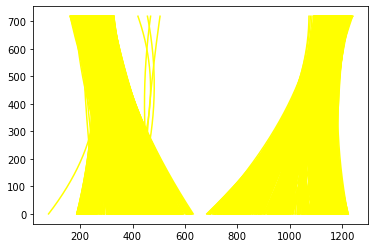

In [38]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#init frame number count, for debug use
zFrame = globalVar()
zFrame.value = 1

#init sanity check counter
zSanityCounter = globalVar()
zSanityCounter.value = 0

#init left and right lane line classes
left_Line = Line()
right_Line = Line()

#init array to store left and right poly coefficients for smooth calculation
left_Line.best_fit_list = np.empty([0,3])
right_Line.best_fit_list = np.empty([0,3])

#init array to store left and right fitted x values for smooth calculation
left_Line.recent_xfitted = np.empty([0,720])
right_Line.recent_xfitted = np.empty([0,720])

#init list to store left and right curvatures for smooth calculation
left_Line.curvatures = list()
right_Line.curvatures = list()

#name the output video file
white_output = 'project_video_out.mp4'

#define path and name of the input video file
clip1 = VideoFileClip("project_video.mp4")#.subclip(0,5)

#process the input video with the pipeline function
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [33]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(white_output))